In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.plotting.register_matplotlib_converters()
from scipy.stats import probplot

import matplotlib.pyplot as plt
import seaborn as sns

## 1. Introduction

In [2]:
df_generation = pd.read_csv('../input/enerjisa-enerji-veri-maratonu/generation.csv', sep=';')
df_generation = df_generation.dropna()

df_temperature = pd.read_csv('../input/enerjisa-enerji-veri-maratonu/temperature.csv', sep=';')
df_temperature = df_temperature.loc[~df_temperature['DateTime'].isnull(), :]

df_train = df_generation.merge(df_temperature, how='left', on='DateTime')
df_sample_submission = pd.read_csv('../input/enerjisa-enerji-veri-maratonu/sample_submission.csv', sep=',')
df_test = df_sample_submission.merge(df_temperature, how='left', on='DateTime')

# Assign appropriate data types to columns
for dataset, df in zip(['train', 'test'], [df_train, df_test]):
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    if dataset == 'train':
        df['Generation'] = df['Generation'].str.replace(',', '.').astype(np.float64)
    else:
        df['Generation'] = df['Generation'].astype(np.float64)
    df['AirTemperature'] = df['AirTemperature'].str.replace(',', '.').astype(np.float32)
    df['ComfortTemperature'] = df['ComfortTemperature'].str.replace(',', '.').astype(np.float32)
    df['RelativeHumidity'] = df['RelativeHumidity'].str.replace(',', '.').astype(np.float32)
    df['WindSpeed'] = df['WindSpeed'].str.replace(',', '.').astype(np.float32)
    df['WindDirection'] = df['WindDirection'].astype(np.float32)
    df['WWCode'] = df['WWCode'].astype(np.float32)
    df['EffectiveCloudCover'] = df['EffectiveCloudCover'].str.replace(',', '.').astype(np.float32)

print(f'Training Set Shape: {df_train.shape} - Memory Usage: {df_train.memory_usage().sum() / 1024 ** 2:.2f} MB')
print(f'Test Set Shape: {df_test.shape} - Memory Usage: {df_test.memory_usage().sum() / 1024 ** 2:.2f} MB')

del df_generation, df_temperature, df_sample_submission

Training Set Shape: (25560, 9) - Memory Usage: 1.27 MB
Test Set Shape: (744, 9) - Memory Usage: 0.04 MB


In [3]:
for df in [df_train, df_test]:
    
    df['Date'] = pd.to_datetime(df['DateTime'].dt.date)
    df['Time'] = df['DateTime'].dt.time
    df['Year'] = df['DateTime'].dt.year
    df['Month'] = df['DateTime'].dt.month
    df['DayOfMonth'] = df['DateTime'].dt.day
    df['HourOfDay'] = df['DateTime'].dt.hour
    df['WeekOfYear'] = df['DateTime'].dt.isocalendar().week
    df['DayOfWeek'] = df['DateTime'].dt.dayofweek
    df['DayOfYear'] = df['DateTime'].dt.dayofyear


## 2. Target

Generation
----------
Mean: 89.7242  -  Median: 4.3171  -  Std: 126.1801
Min: 0.0000  -  25%: 0.0000  -  50%: 4.3171  -  75%: 168.4985  -  Max: 456.3193
Skew: 1.1735  -  Kurtosis: -0.0345
Missing Values: 0/25560 (0.0000%)


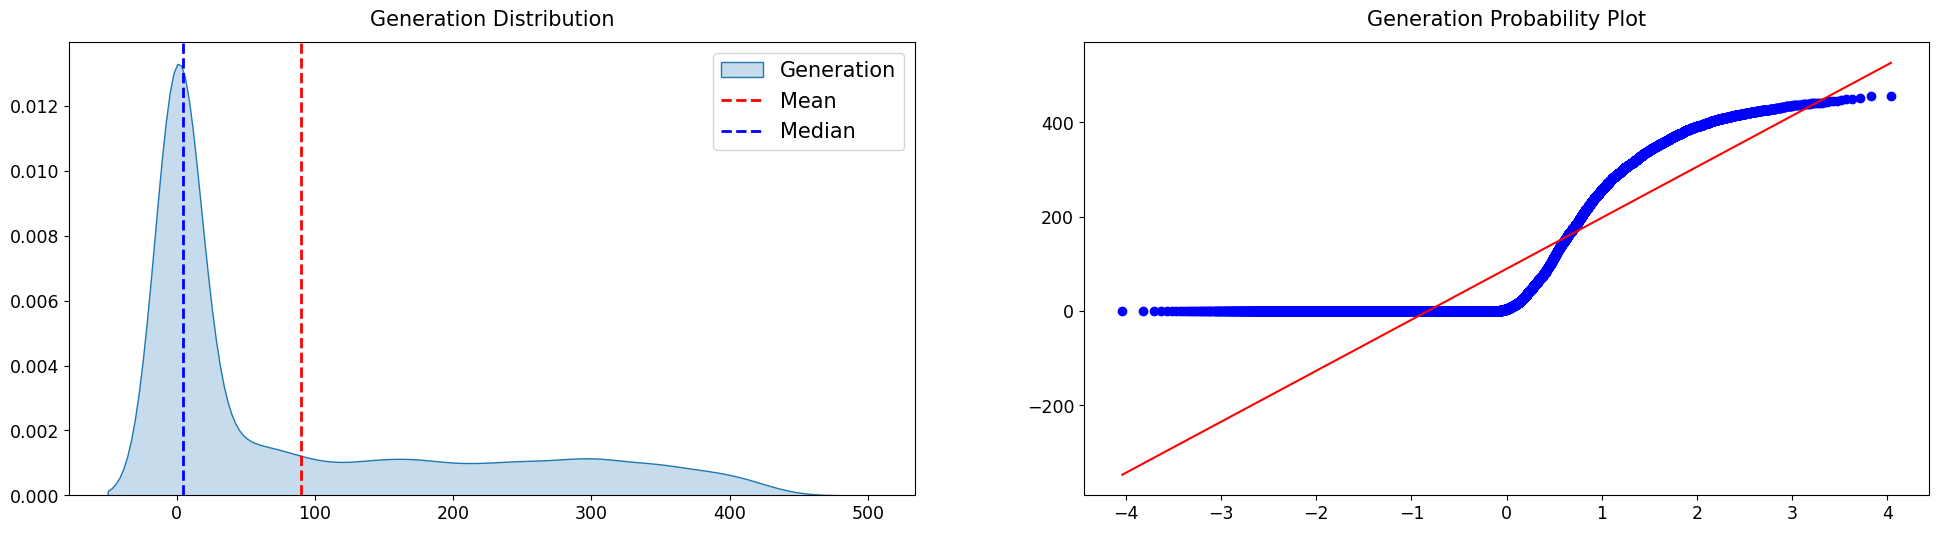

In [4]:
def visualize_target(df, target):
    
    print(f'{target}\n{"-" * len(target)}')
        
    print(f'Mean: {df[target].mean():.4f}  -  Median: {df[target].median():.4f}  -  Std: {df[target].std():.4f}')
    print(f'Min: {df[target].min():.4f}  -  25%: {df[target].quantile(0.25):.4f}  -  50%: {df[target].quantile(0.5):.4f}  -  75%: {df[target].quantile(0.75):.4f}  -  Max: {df[target].max():.4f}')
    print(f'Skew: {df[target].skew():.4f}  -  Kurtosis: {df[target].kurtosis():.4f}')
    missing_count = df[df[target].isnull()].shape[0]
    total_count = df.shape[0]
    print(f'Missing Values: {missing_count}/{total_count} ({missing_count * 100 / total_count:.4f}%)')

    fig, axes = plt.subplots(ncols=2, figsize=(24, 6), dpi=100)

    sns.kdeplot(df[target], label=target, fill=True, ax=axes[0])
    axes[0].axvline(df[target].mean(), label='Mean', color='r', linewidth=2, linestyle='--')
    axes[0].axvline(df[target].median(), label='Median', color='b', linewidth=2, linestyle='--')
    axes[0].legend(prop={'size': 15})
    probplot(df[target], plot=axes[1])
    
    for i in range(2):
        axes[i].tick_params(axis='x', labelsize=12.5)
        axes[i].tick_params(axis='y', labelsize=12.5)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')
    axes[0].set_title(f'{target} Distribution', fontsize=15, pad=12)
    axes[1].set_title(f'{target} Probability Plot', fontsize=15, pad=12)
    
    plt.show()

visualize_target(df_train, 'Generation')

## 3. Time

In [5]:
def visualize_time(df, column):
    
    print(f'{column}\n{"-" * len(column)}')
    print(f'Mean: {df[column].mean():.4f}  -  Median: {df[column].median():.4f}  -  Std: {df[column].std():.4f}')
    print(f'Min: {df[column].min():.4f}  -  25%: {df[column].quantile(0.25):.4f}  -  50%: {df[column].quantile(0.5):.4f}  -  75%: {df[column].quantile(0.75):.4f}  -  Max: {df[column].max():.4f}')
    print(f'Skew: {df[column].skew():.4f}  -  Kurtosis: {df[column].kurtosis():.4f}')
    missing_count = df[df[column].isnull()].shape[0]
    total_count = df.shape[0]
    print(f'Missing Values: {missing_count}/{total_count} ({missing_count * 100 / total_count:.4f}%)')

    fig, axes = plt.subplots(ncols=2, figsize=(24, 6), dpi=100)

    sns.kdeplot(df[column], label=column, fill=True, ax=axes[0])
    axes[0].axvline(df[column].mean(), label='Mean', color='r', linewidth=2, linestyle='--')
    axes[0].axvline(df[column].median(), label='Median', color='b', linewidth=2, linestyle='--')
    axes[0].legend(prop={'size': 15})
    axes[1].plot(df[column], label=column)
    
    for i in range(2):
        axes[i].tick_params(axis='x', labelsize=12.5)
        axes[i].tick_params(axis='y', labelsize=12.5)
        axes[i].set_ylabel('')
    axes[0].set_xlabel('')
    axes[1].set_xlabel('Time', fontsize=12.5)
    axes[0].set_title(f'{column} Distribution', fontsize=15, pad=12)
    axes[1].set_title(f'{column} as a Function of Time', fontsize=15, pad=12)
    
    plt.show()


sample_counts_in_dates
----------------------
Mean: 24.0000  -  Median: 24.0000  -  Std: 0.0000
Min: 24.0000  -  25%: 24.0000  -  50%: 24.0000  -  75%: 24.0000  -  Max: 24.0000
Skew: 0.0000  -  Kurtosis: 0.0000
Missing Values: 0/1065 (0.0000%)


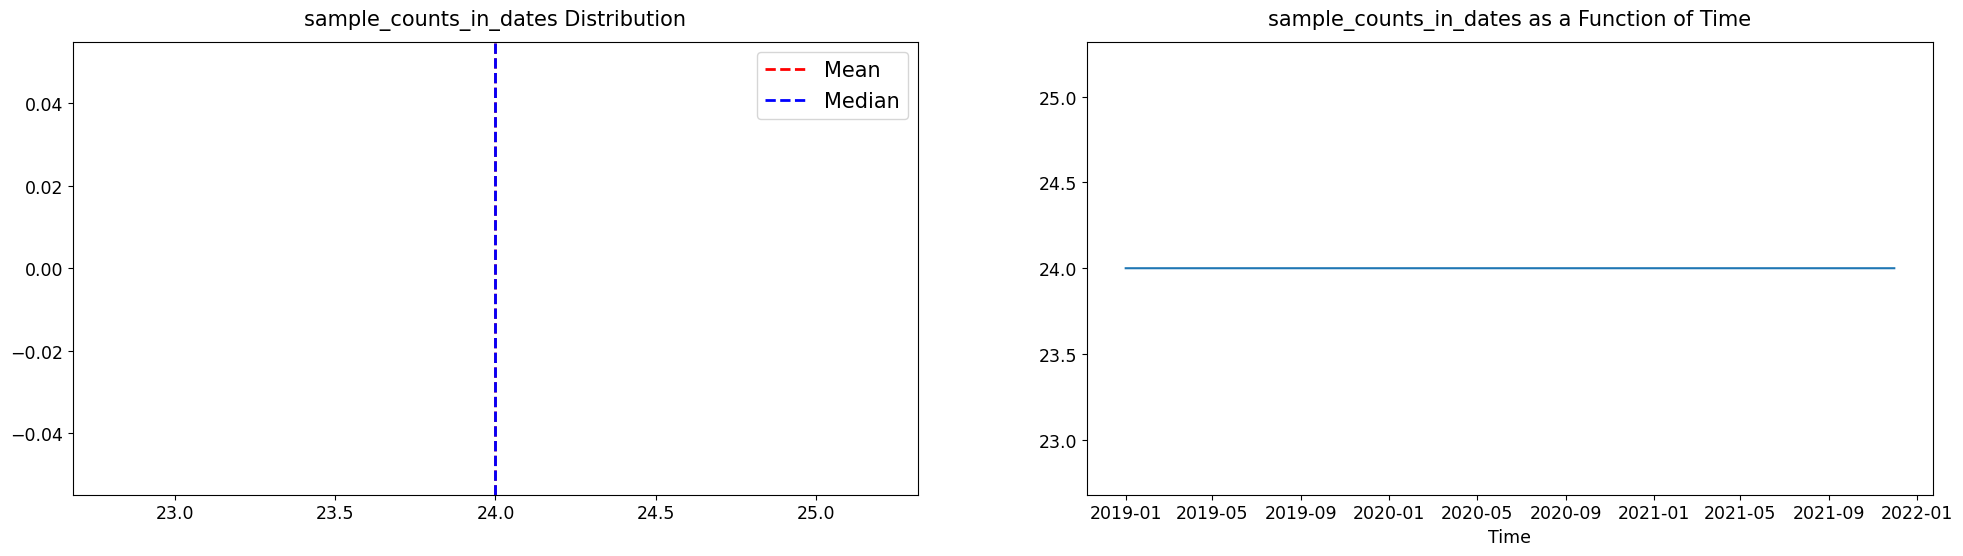

In [6]:
df = df_train.groupby('Date')['Generation'].count().reset_index().rename(columns={'Generation': 'sample_counts_in_dates'}).set_index('Date')
visualize_time(df, 'sample_counts_in_dates')

generation_means_in_dates
-------------------------
Mean: 89.7242  -  Median: 94.3580  -  Std: 37.8898
Min: 1.4790  -  25%: 64.3885  -  50%: 94.3580  -  75%: 120.5488  -  Max: 160.1249
Skew: -0.4026  -  Kurtosis: -0.7657
Missing Values: 0/1065 (0.0000%)


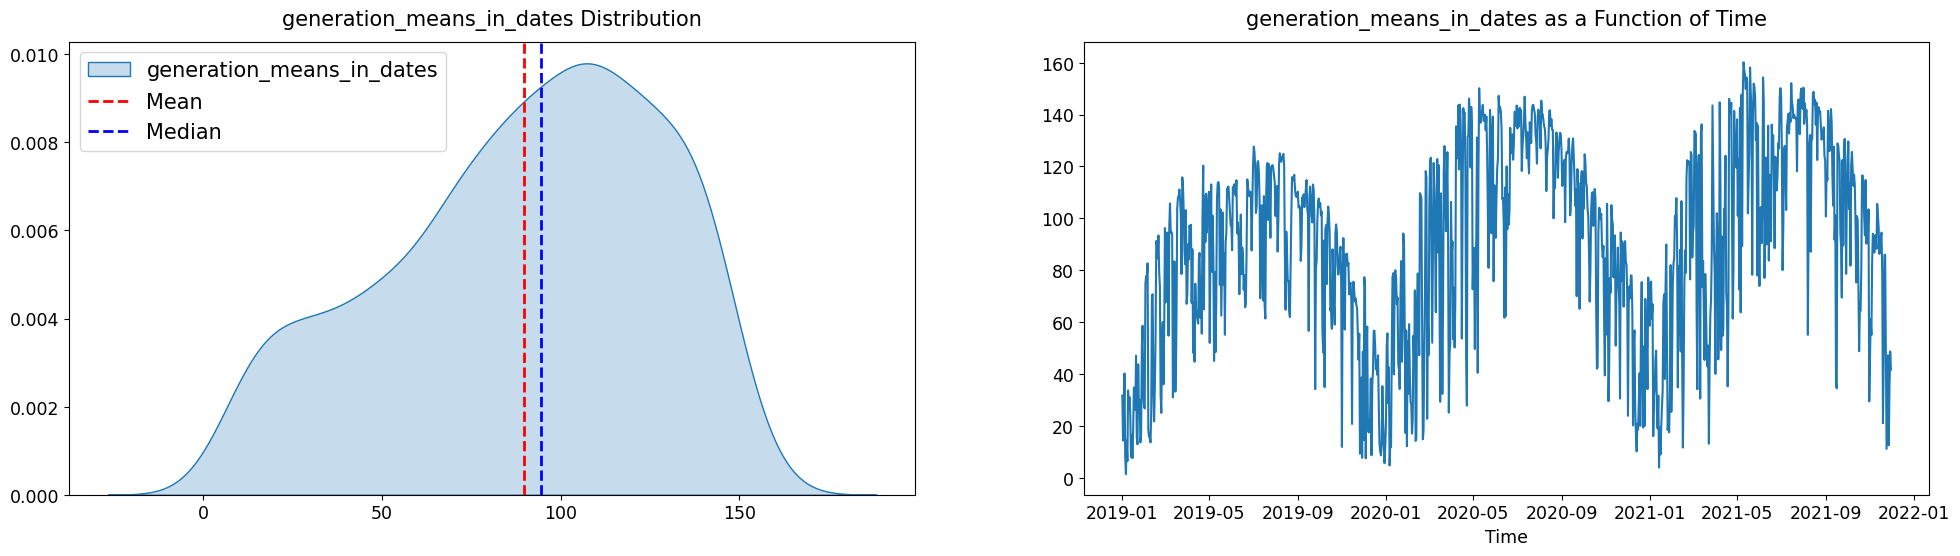

In [7]:
df = df_train.groupby('Date')['Generation'].mean().reset_index().rename(columns={'Generation': 'generation_means_in_dates'}).set_index('Date')
visualize_time(df, 'generation_means_in_dates')

generation_stds_in_dates
------------------------
Mean: 115.1844  -  Median: 124.7710  -  Std: 43.0193
Min: 2.5383  -  25%: 87.4111  -  50%: 124.7710  -  75%: 148.8307  -  Max: 188.8013
Skew: -0.6436  -  Kurtosis: -0.4781
Missing Values: 0/1065 (0.0000%)


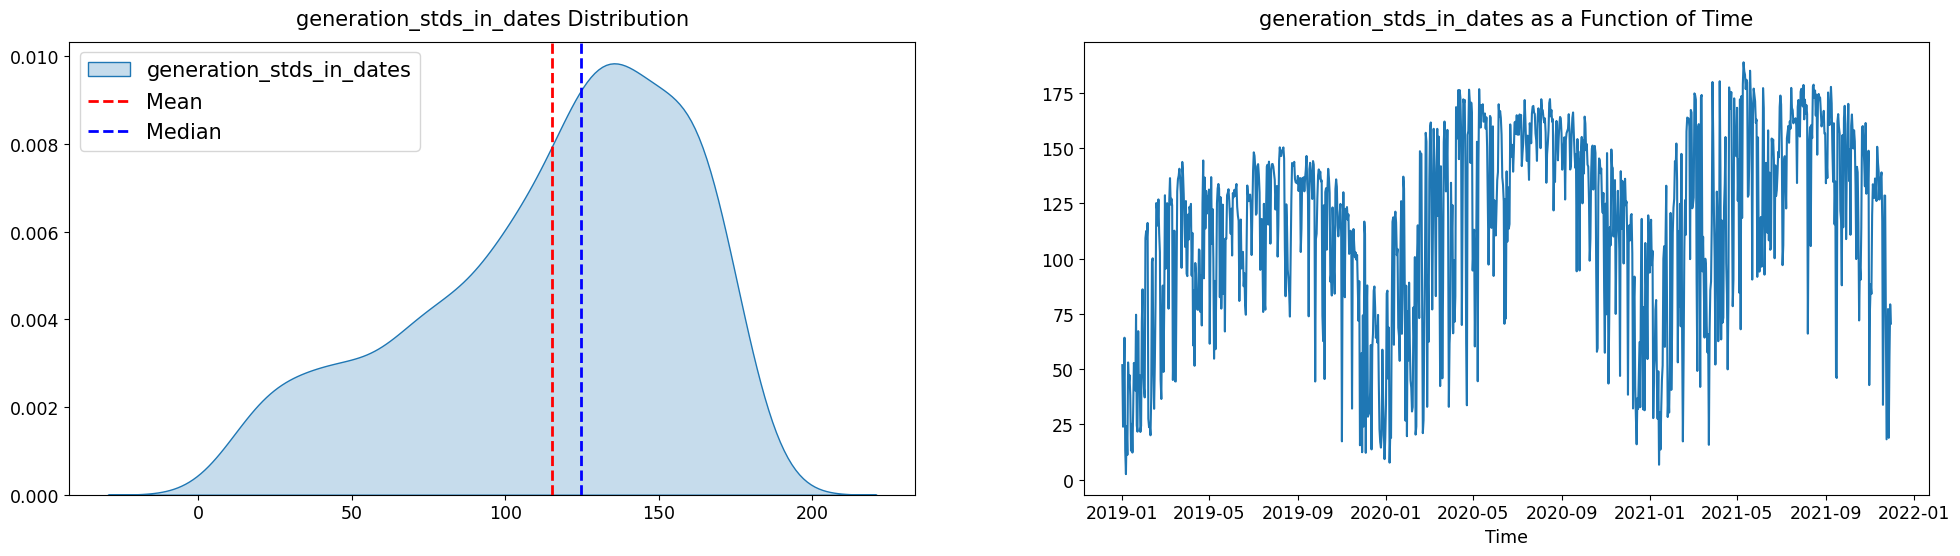

In [8]:
df = df_train.groupby('Date')['Generation'].std().reset_index().rename(columns={'Generation': 'generation_stds_in_dates'}).set_index('Date')
visualize_time(df, 'generation_stds_in_dates')

sample_counts_in_times
----------------------
Mean: 1065.0000  -  Median: 1065.0000  -  Std: 0.0000
Min: 1065.0000  -  25%: 1065.0000  -  50%: 1065.0000  -  75%: 1065.0000  -  Max: 1065.0000
Skew: 0.0000  -  Kurtosis: 0.0000
Missing Values: 0/24 (0.0000%)


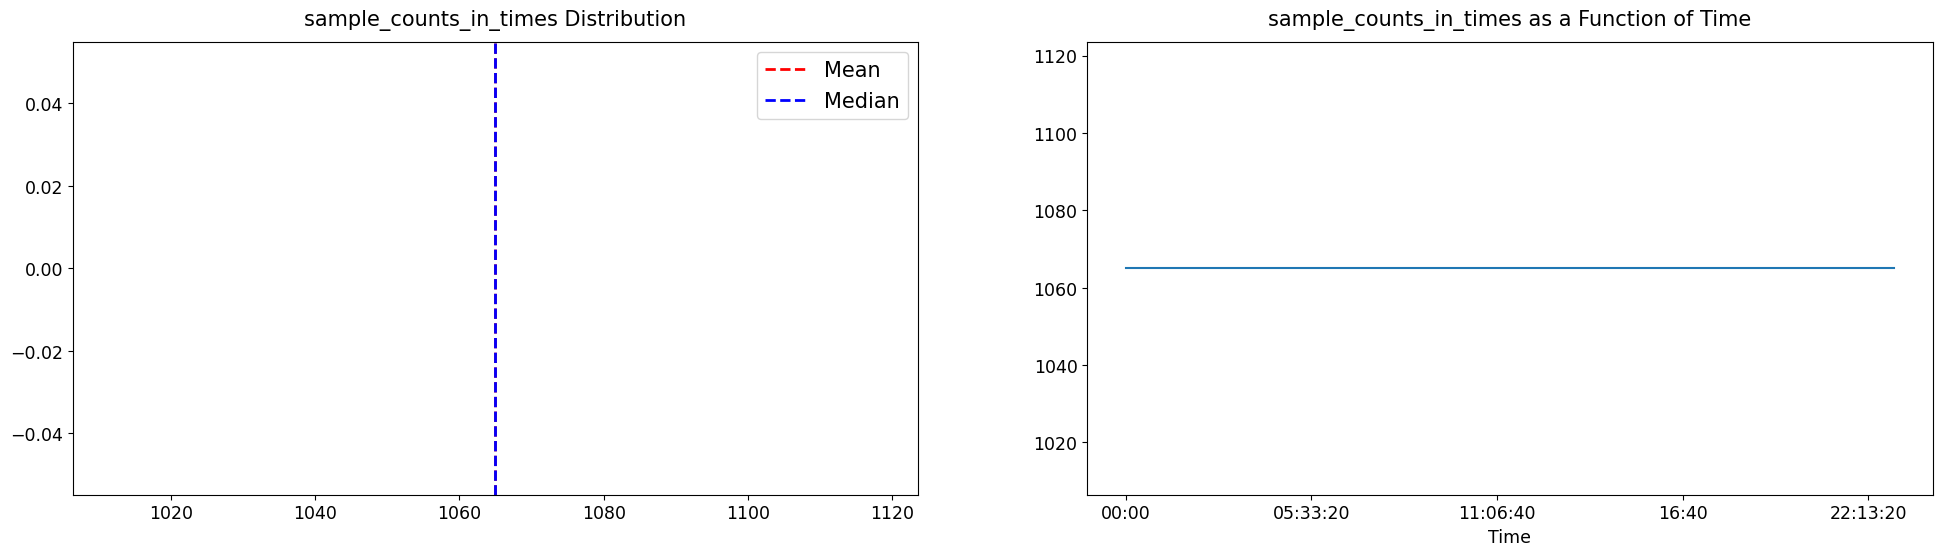

In [9]:
df = df_train.groupby('Time')['Generation'].count().reset_index().rename(columns={'Generation': 'sample_counts_in_times'}).set_index('Time')
visualize_time(df, 'sample_counts_in_times')

generation_means_in_times
-------------------------
Mean: 89.7242  -  Median: 14.9937  -  Std: 113.3032
Min: 0.0005  -  25%: 0.0034  -  50%: 14.9937  -  75%: 194.8326  -  Max: 291.0435
Skew: 0.8080  -  Kurtosis: -1.0969
Missing Values: 0/24 (0.0000%)


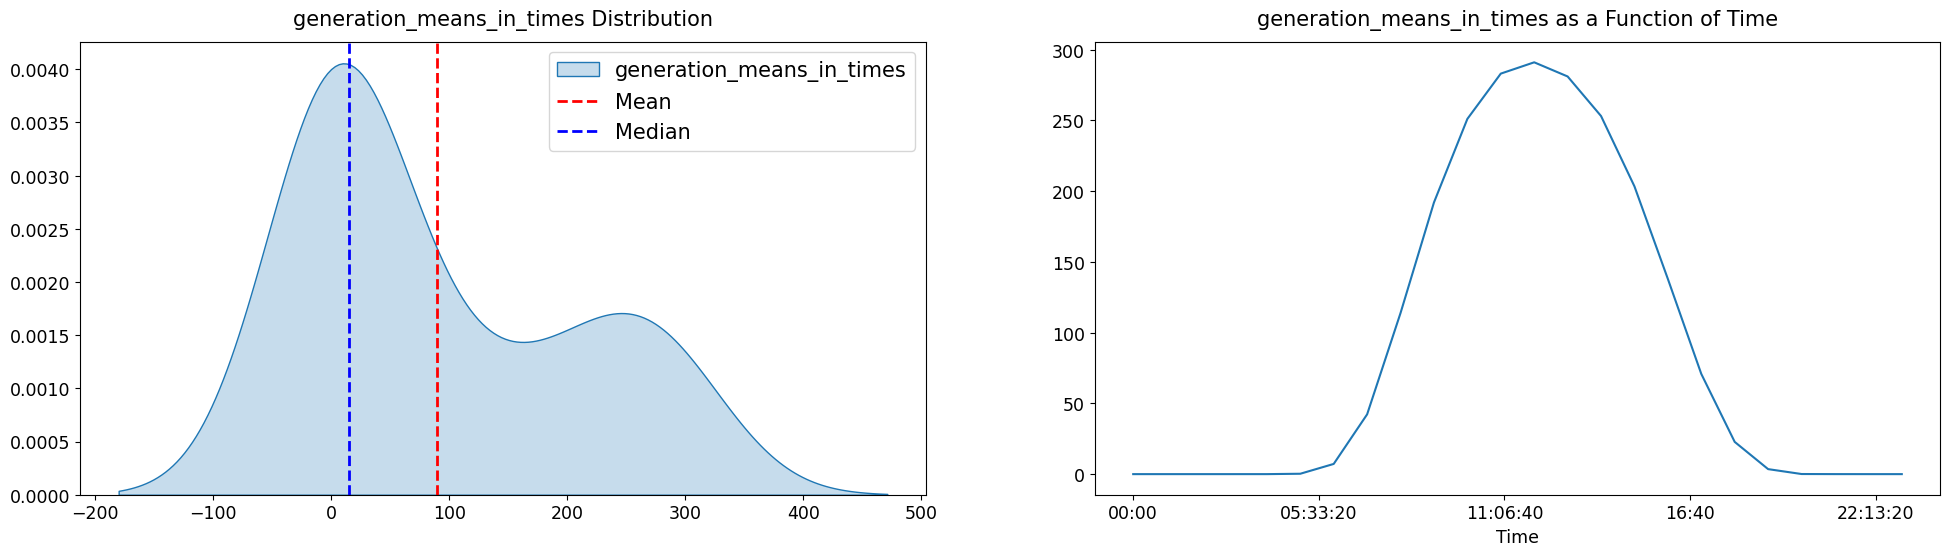

In [10]:
df = df_train.groupby('Time')['Generation'].mean().reset_index().rename(columns={'Generation': 'generation_means_in_times'}).set_index('Time')
visualize_time(df, 'generation_means_in_times')

generation_stds_in_times
------------------------
Mean: 40.7929  -  Median: 16.8137  -  Std: 45.1943
Min: 0.0017  -  25%: 0.0150  -  50%: 16.8137  -  75%: 89.1356  -  Max: 106.2274
Skew: 0.4510  -  Kurtosis: -1.6961
Missing Values: 0/24 (0.0000%)


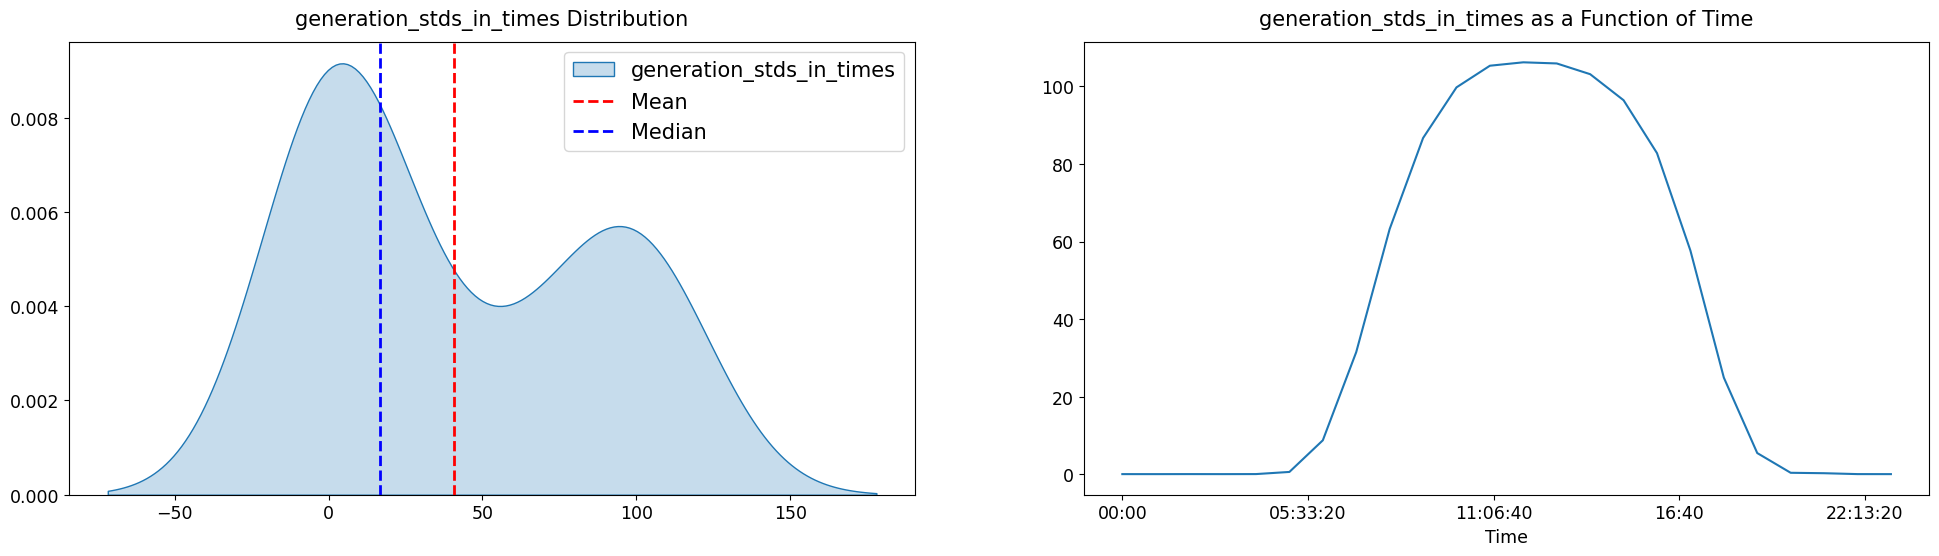

In [11]:
df = df_train.groupby('Time')['Generation'].std().reset_index().rename(columns={'Generation': 'generation_stds_in_times'}).set_index('Time')
visualize_time(df, 'generation_stds_in_times')

## 4. Features

In [12]:
def visualize_feature(df, column):
    
    print(f'{column}\n{"-" * len(column)}')
    print(f'Mean: {df[column].mean():.4f}  -  Median: {df[column].median():.4f}  -  Std: {df[column].std():.4f}')
    print(f'Min: {df[column].min():.4f}  -  25%: {df[column].quantile(0.25):.4f}  -  50%: {df[column].quantile(0.5):.4f}  -  75%: {df[column].quantile(0.75):.4f}  -  Max: {df[column].max():.4f}')
    print(f'Skew: {df[column].skew():.4f}  -  Kurtosis: {df[column].kurtosis():.4f}')
    missing_count = df[df[column].isnull()].shape[0]
    total_count = df.shape[0]
    print(f'Missing Values: {missing_count}/{total_count} ({missing_count * 100 / total_count:.4f}%)')

    fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(24, 22), dpi=100)

    sns.kdeplot(df[column], hue=df['Dataset'], label=column, fill=True, ax=axes[0][0])
    axes[0][0].legend(prop={'size': 15})
    sns.scatterplot(x=df[column], y=df['Generation'], ax=axes[0][1])
    
    df_feature_means_in_dates = df.groupby('Date')[column].mean().reset_index().rename(columns={column: f'{column}_means_in_dates'})
    axes[1][0].plot(df_feature_means_in_dates.loc[df_feature_means_in_dates['Date'] < '2021-12-01', :].set_index('Date')[f'{column}_means_in_dates'], label=f'Train {column}_means_in_dates')
    axes[1][0].plot(df_feature_means_in_dates.loc[df_feature_means_in_dates['Date'] >= '2021-12-01', :].set_index('Date')[f'{column}_means_in_dates'], label=f'Test {column}_means_in_dates')
    axes[1][0].legend(prop={'size': 15})
    df_feature_stds_in_dates = df.groupby('Date')[column].std().reset_index().rename(columns={column: f'{column}_stds_in_dates'})
    axes[1][1].plot(df_feature_stds_in_dates.loc[df_feature_stds_in_dates['Date'] < '2021-12-01', :].set_index('Date')[f'{column}_stds_in_dates'], label=f'Train {column}_stds_in_dates')
    axes[1][1].plot(df_feature_stds_in_dates.loc[df_feature_stds_in_dates['Date'] >= '2021-12-01', :].set_index('Date')[f'{column}_stds_in_dates'], label=f'Test {column}_stds_in_dates')
    axes[1][1].legend(prop={'size': 15})
    
    df_feature_means_in_times = df.groupby('Time')[column].mean().reset_index().rename(columns={column: f'{column}_means_in_times'})
    axes[2][0].plot(df_feature_means_in_times.set_index('Time')[f'{column}_means_in_times'], label=f'{column}_means_in_times')
    df_feature_stds_in_times = df.groupby('Time')[column].std().reset_index().rename(columns={column: f'{column}_stds_in_times'})
    axes[2][1].plot(df_feature_stds_in_times.set_index('Time')[f'{column}_stds_in_times'], label=f'{column}_stds_in_times')

    for i in range(3):
        for j in range(2):
            axes[i][j].tick_params(axis='x', labelsize=12.5)
            axes[i][j].tick_params(axis='y', labelsize=12.5)
            axes[i][j].set_ylabel('')
            
    axes[0][0].set_xlabel('')
    axes[0][1].set_xlabel(column, fontsize=12.5)
    axes[0][1].set_ylabel('Generation', fontsize=12.5)
    
    for i in range(2):
        axes[1][i].set_xlabel('Date', fontsize=12.5)
        axes[1][i].set_ylabel(column, fontsize=12.5)
        
    for i in range(2):
        axes[2][i].set_xlabel('Time', fontsize=12.5)
        axes[2][i].set_ylabel(column, fontsize=12.5)
        
    axes[0][0].set_title(f'{column} Distributions', fontsize=15, pad=12)
    axes[0][1].set_title(f'{column} vs Generation', fontsize=15, pad=12)
    axes[1][0].set_title(f'{column} Means as a Function of Date', fontsize=15, pad=12)
    axes[1][1].set_title(f'{column} Stds as a Function of Date', fontsize=15, pad=12)
    axes[2][0].set_title(f'{column} Means as a Function of Time', fontsize=15, pad=12)
    axes[2][1].set_title(f'{column} Stds as a Function of Time', fontsize=15, pad=12)
    
    plt.show()


AirTemperature
--------------
Mean: 13.7415  -  Median: 13.4000  -  Std: 9.3799
Min: -13.1000  -  25%: 6.0000  -  50%: 13.4000  -  75%: 21.0000  -  Max: 39.0000
Skew: 0.1206  -  Kurtosis: -0.8343
Missing Values: 0/26304 (0.0000%)


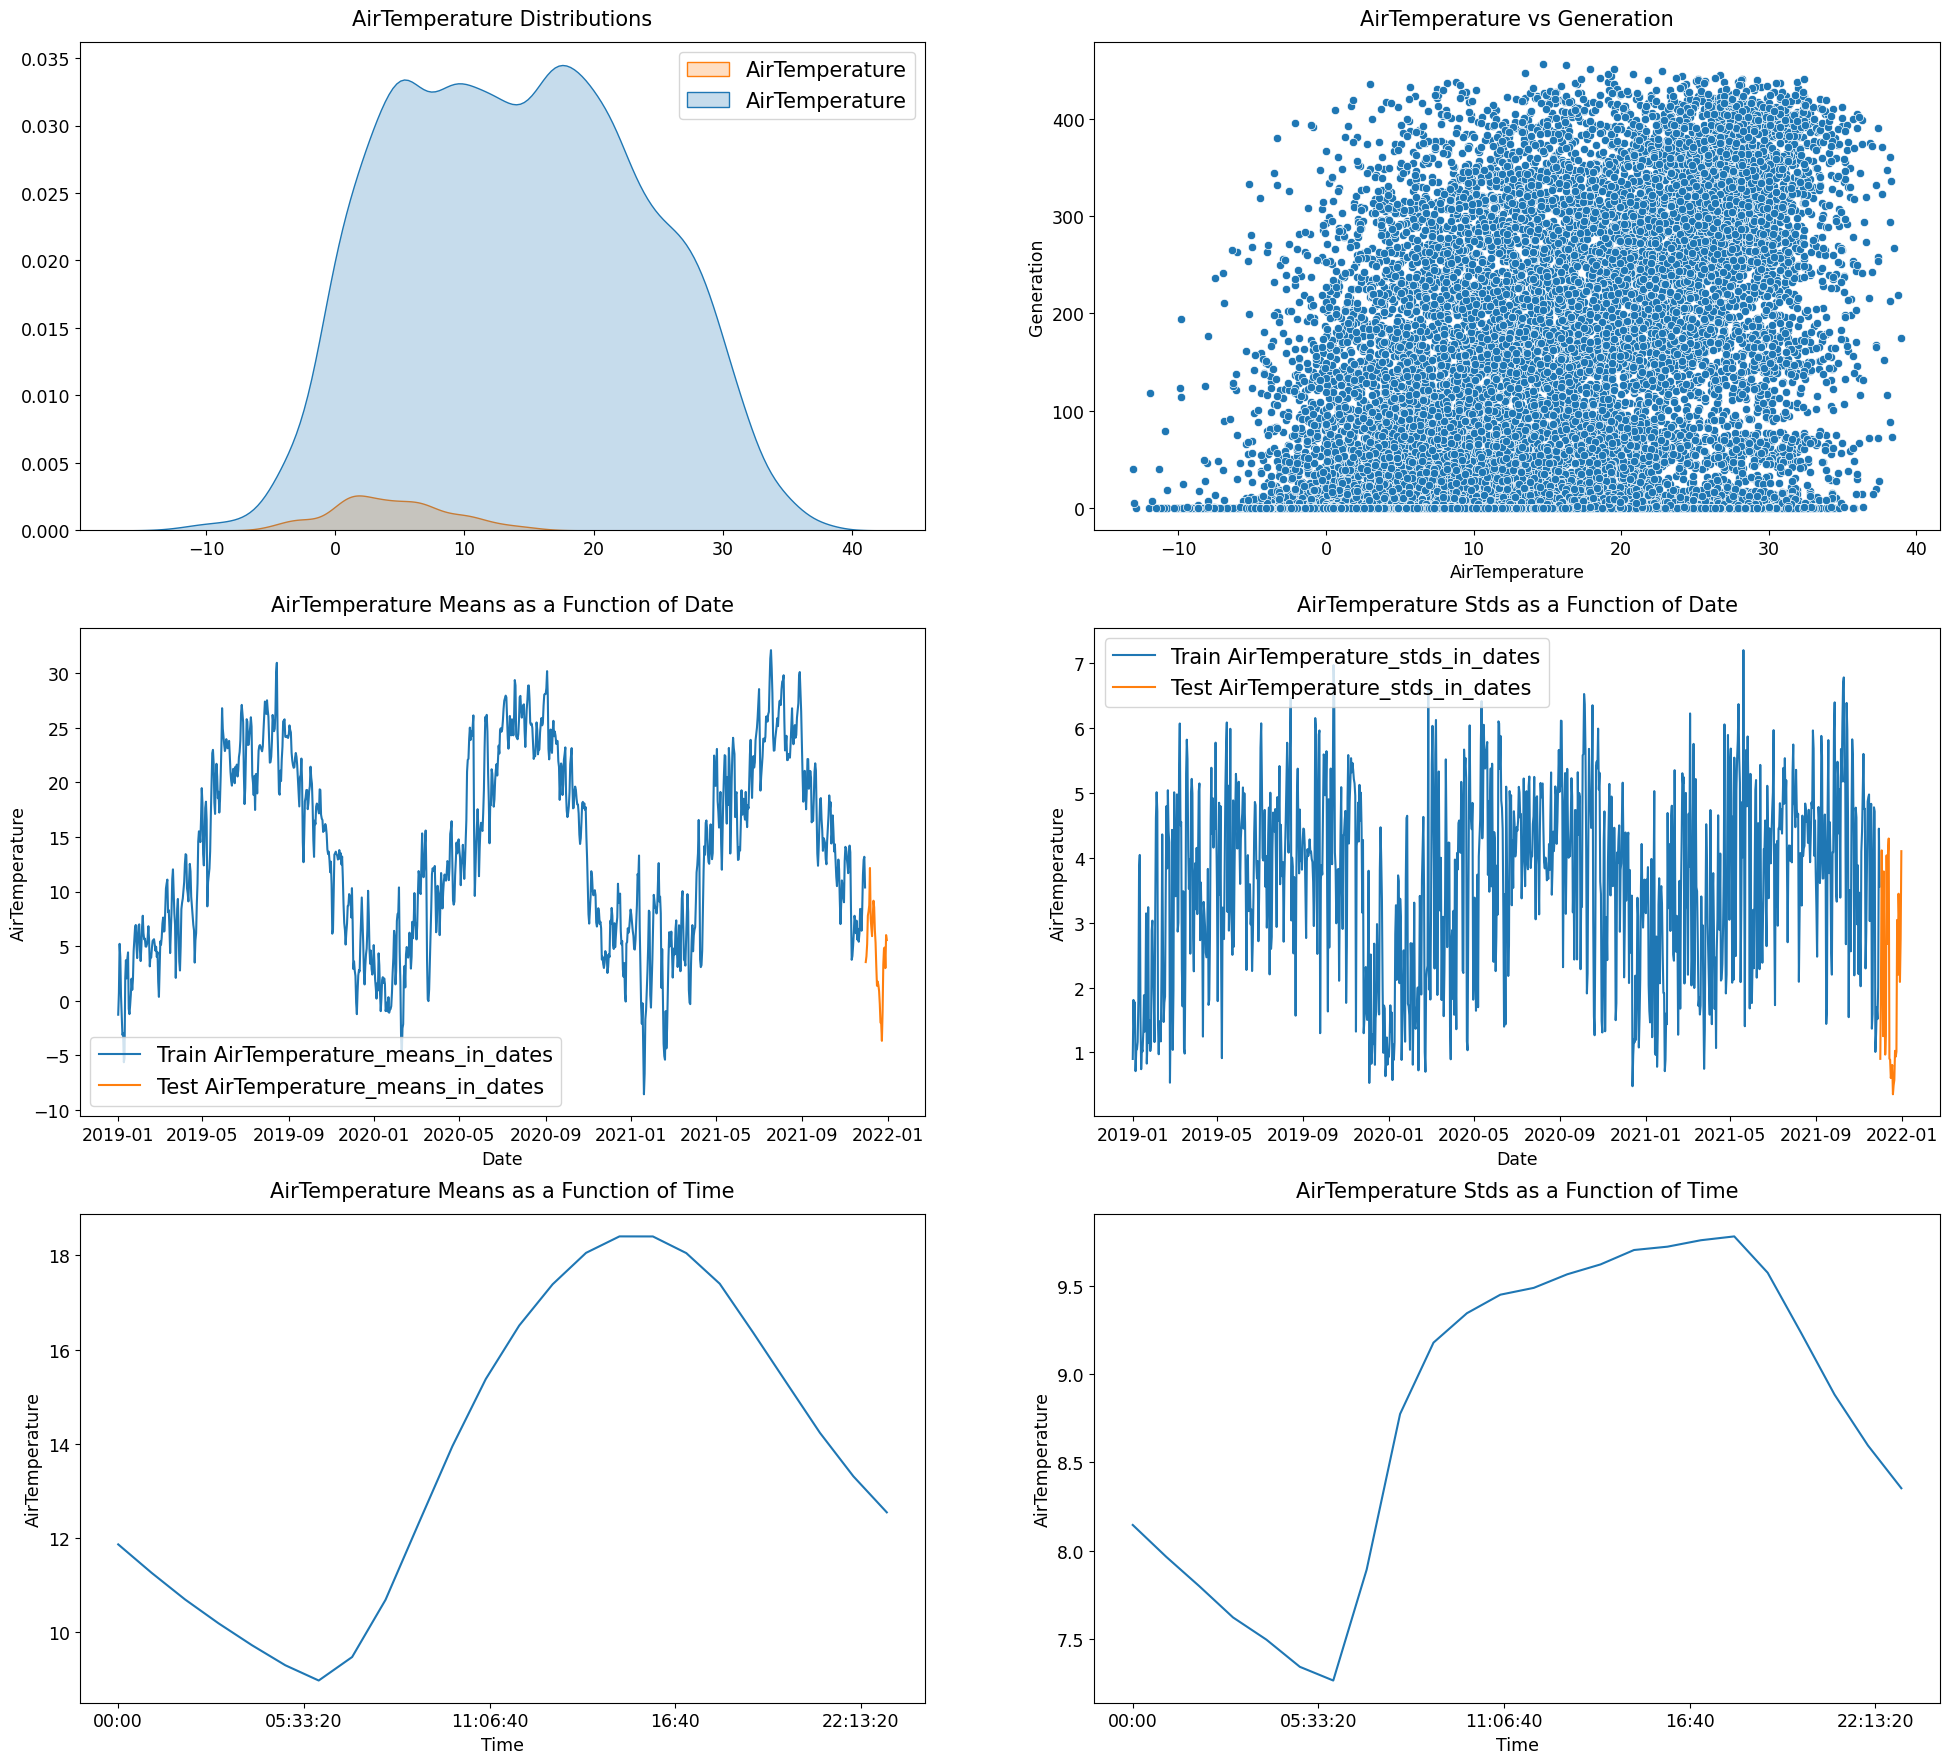

ComfortTemperature
------------------
Mean: 13.2394  -  Median: 13.0000  -  Std: 9.7671
Min: -19.3000  -  25%: 5.1000  -  50%: 13.0000  -  75%: 21.2000  -  Max: 37.2000
Skew: 0.0257  -  Kurtosis: -0.9196
Missing Values: 0/26304 (0.0000%)


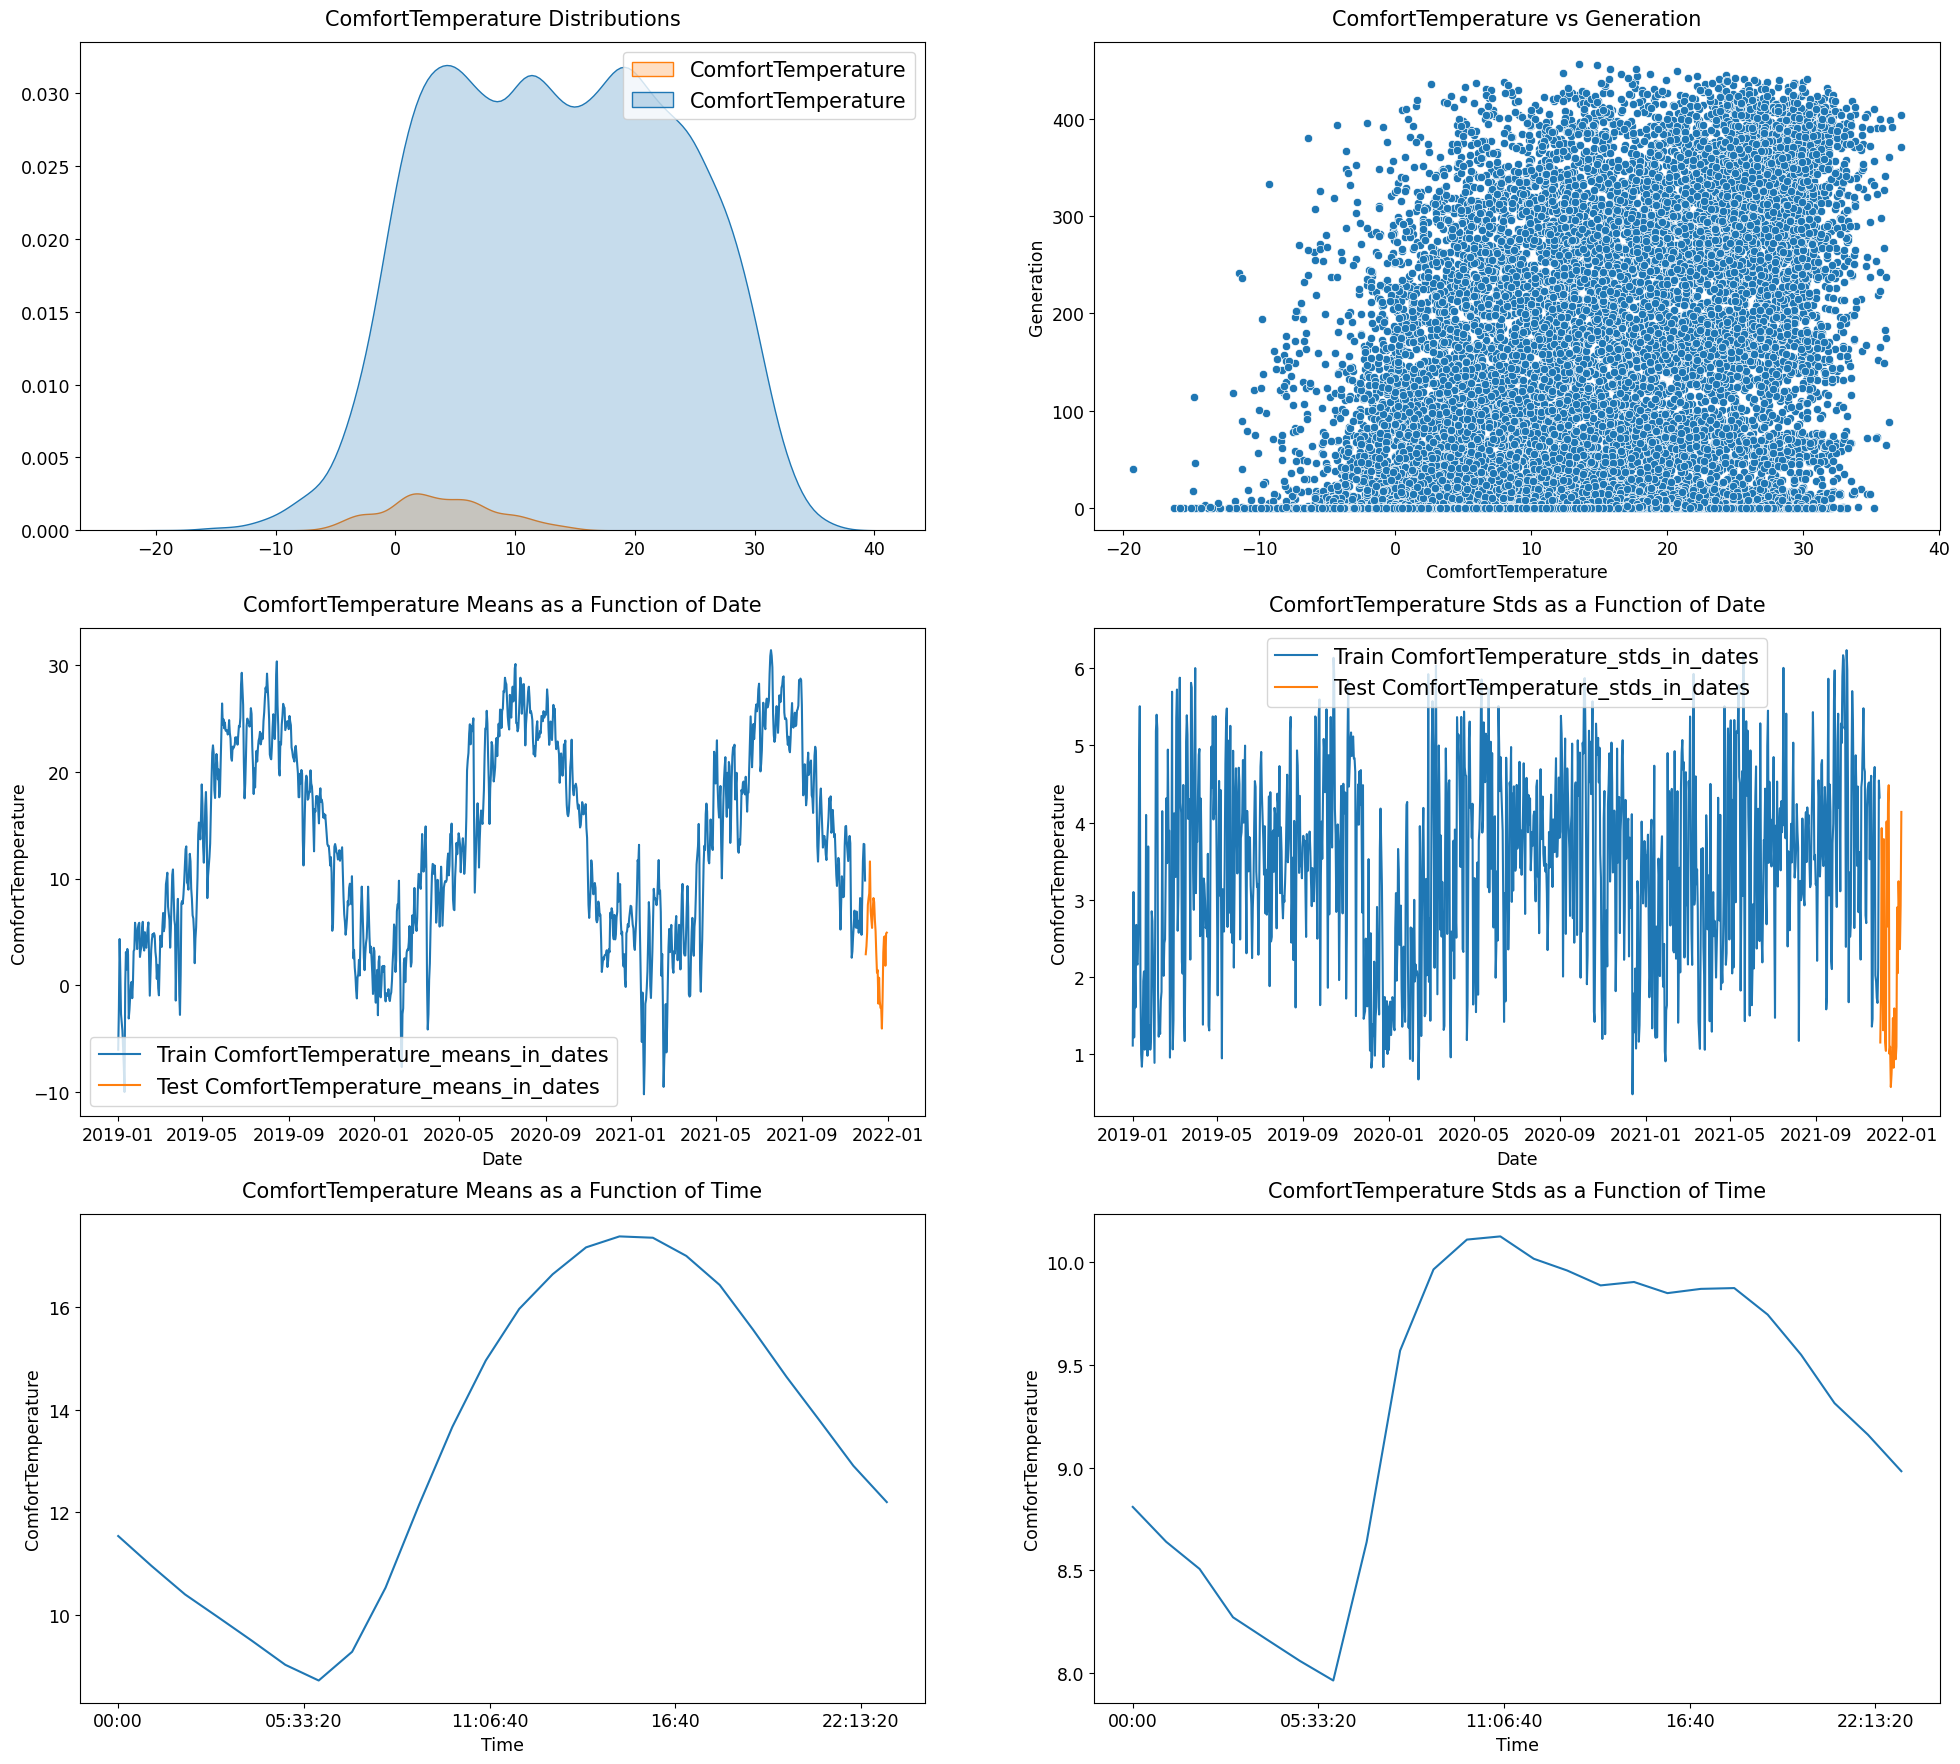

RelativeHumidity
----------------
Mean: 54.3523  -  Median: 55.1000  -  Std: 22.5667
Min: 1.6000  -  25%: 36.6000  -  50%: 55.1000  -  75%: 72.5000  -  Max: 100.0000
Skew: -0.0827  -  Kurtosis: -0.9194
Missing Values: 0/26304 (0.0000%)


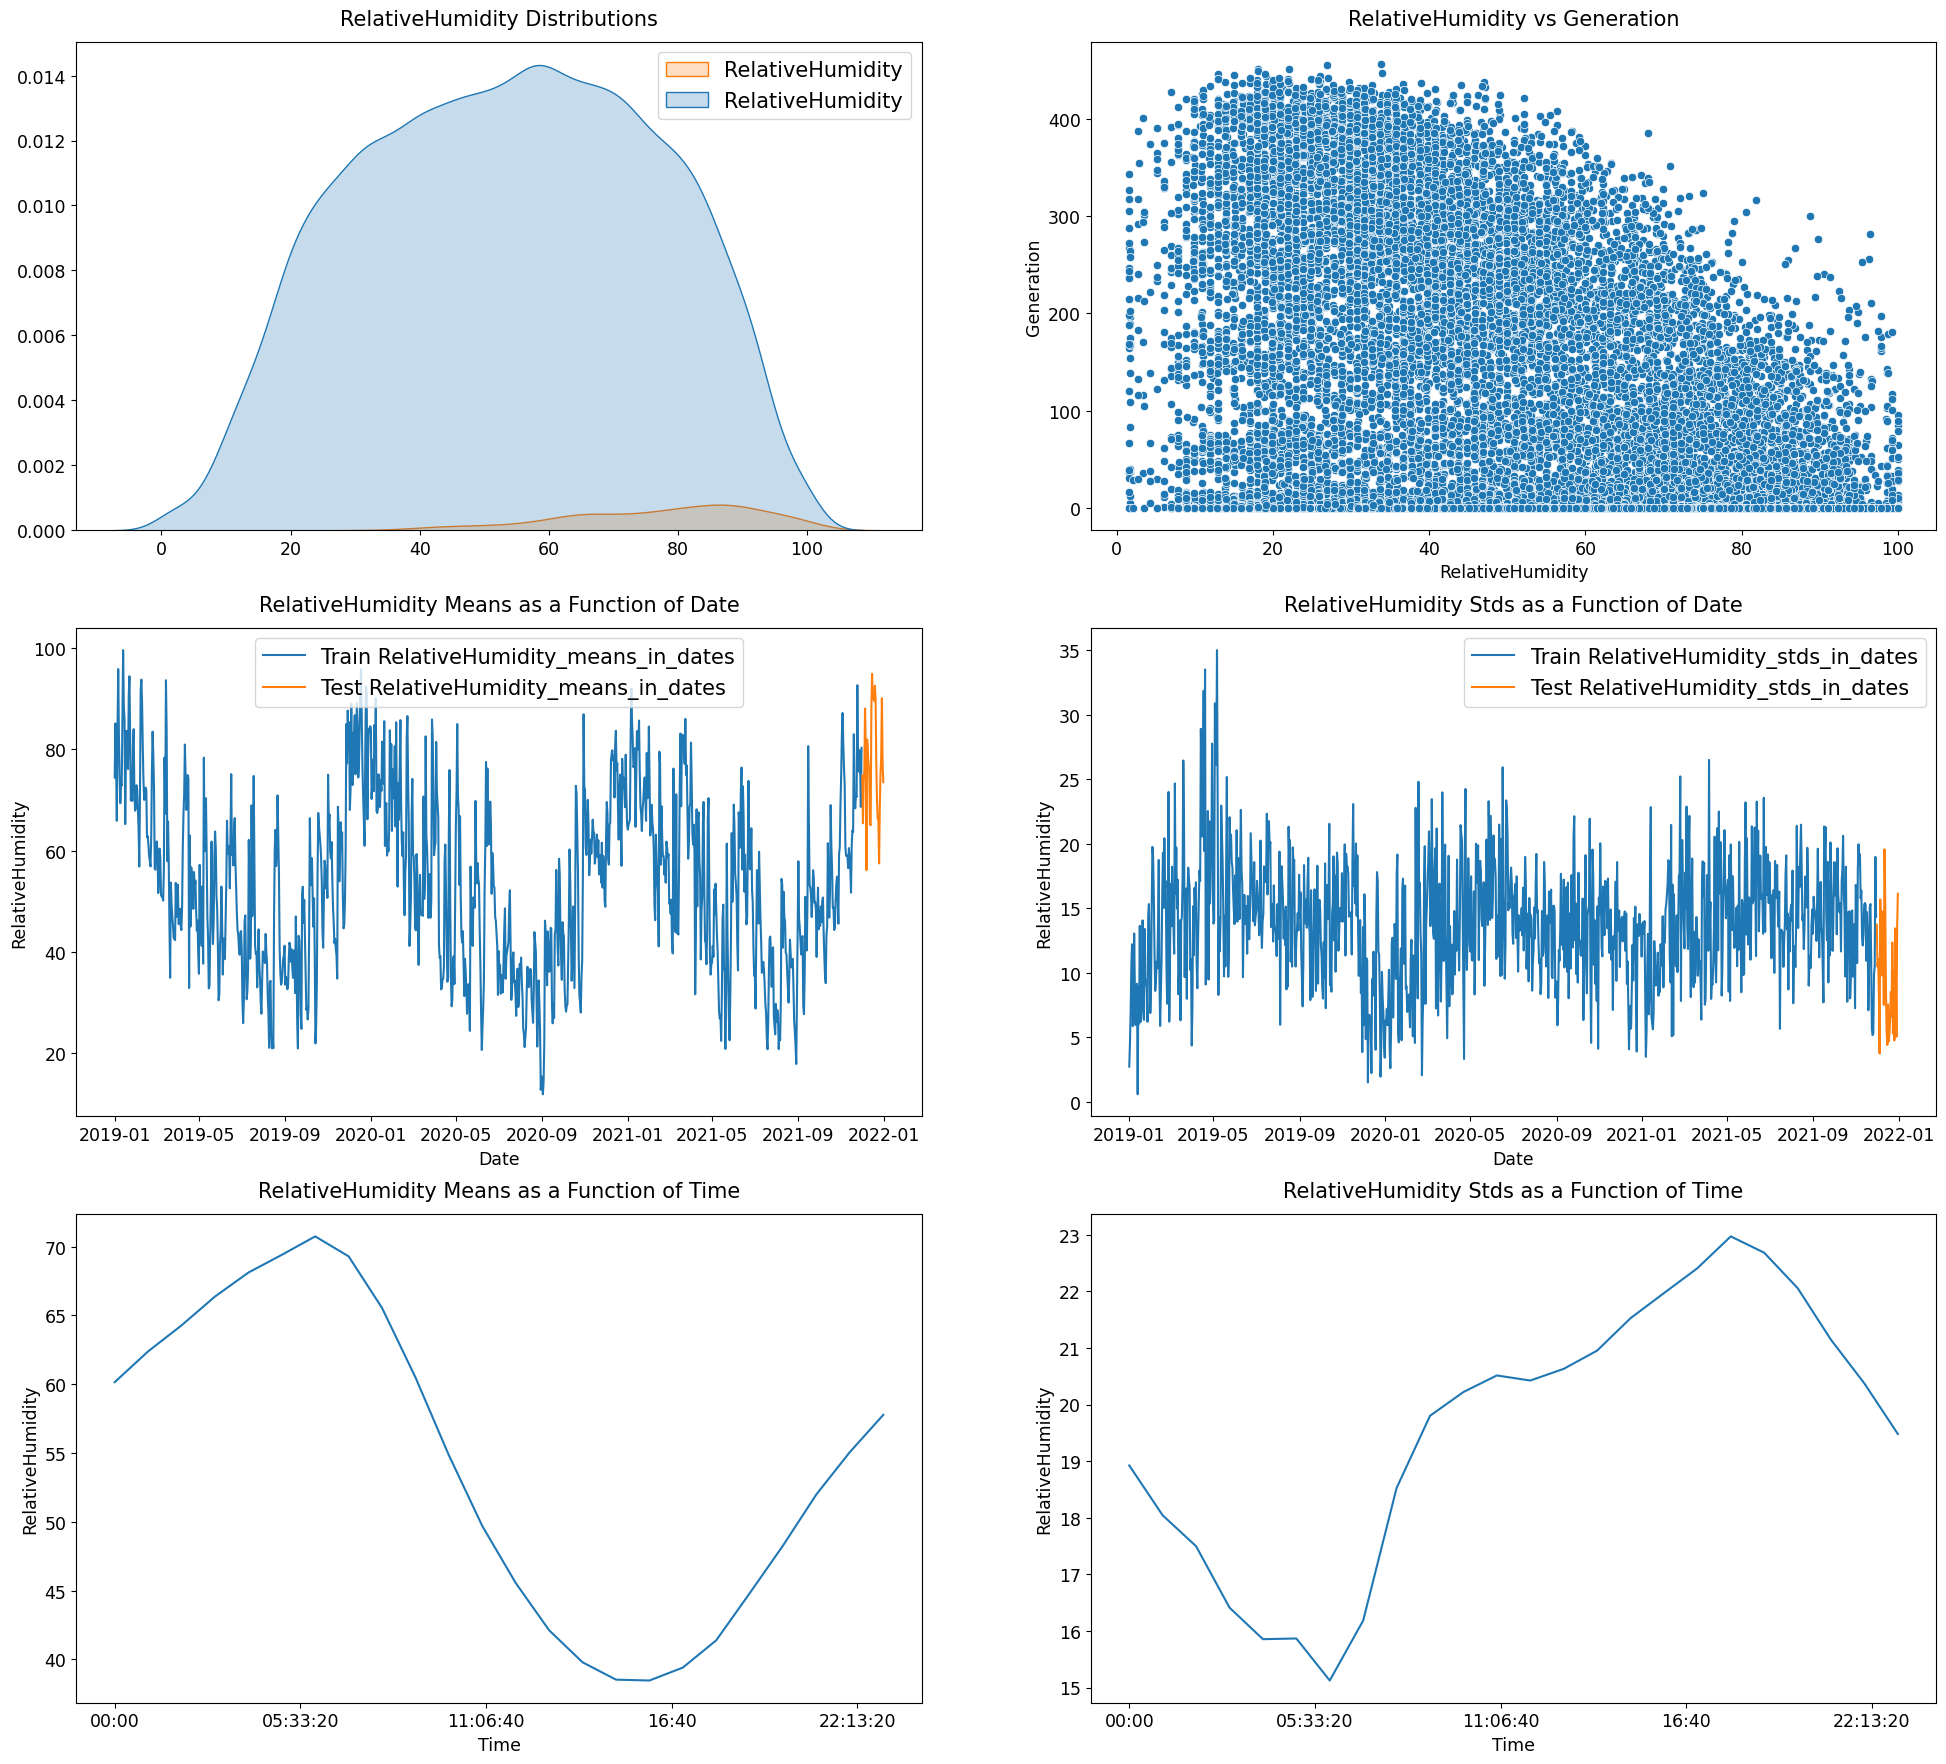

WindSpeed
---------
Mean: 1.6560  -  Median: 1.5000  -  Std: 1.3531
Min: 0.0000  -  25%: 0.5000  -  50%: 1.5000  -  75%: 2.6000  -  Max: 13.4000
Skew: 1.3181  -  Kurtosis: 3.0200
Missing Values: 0/26304 (0.0000%)


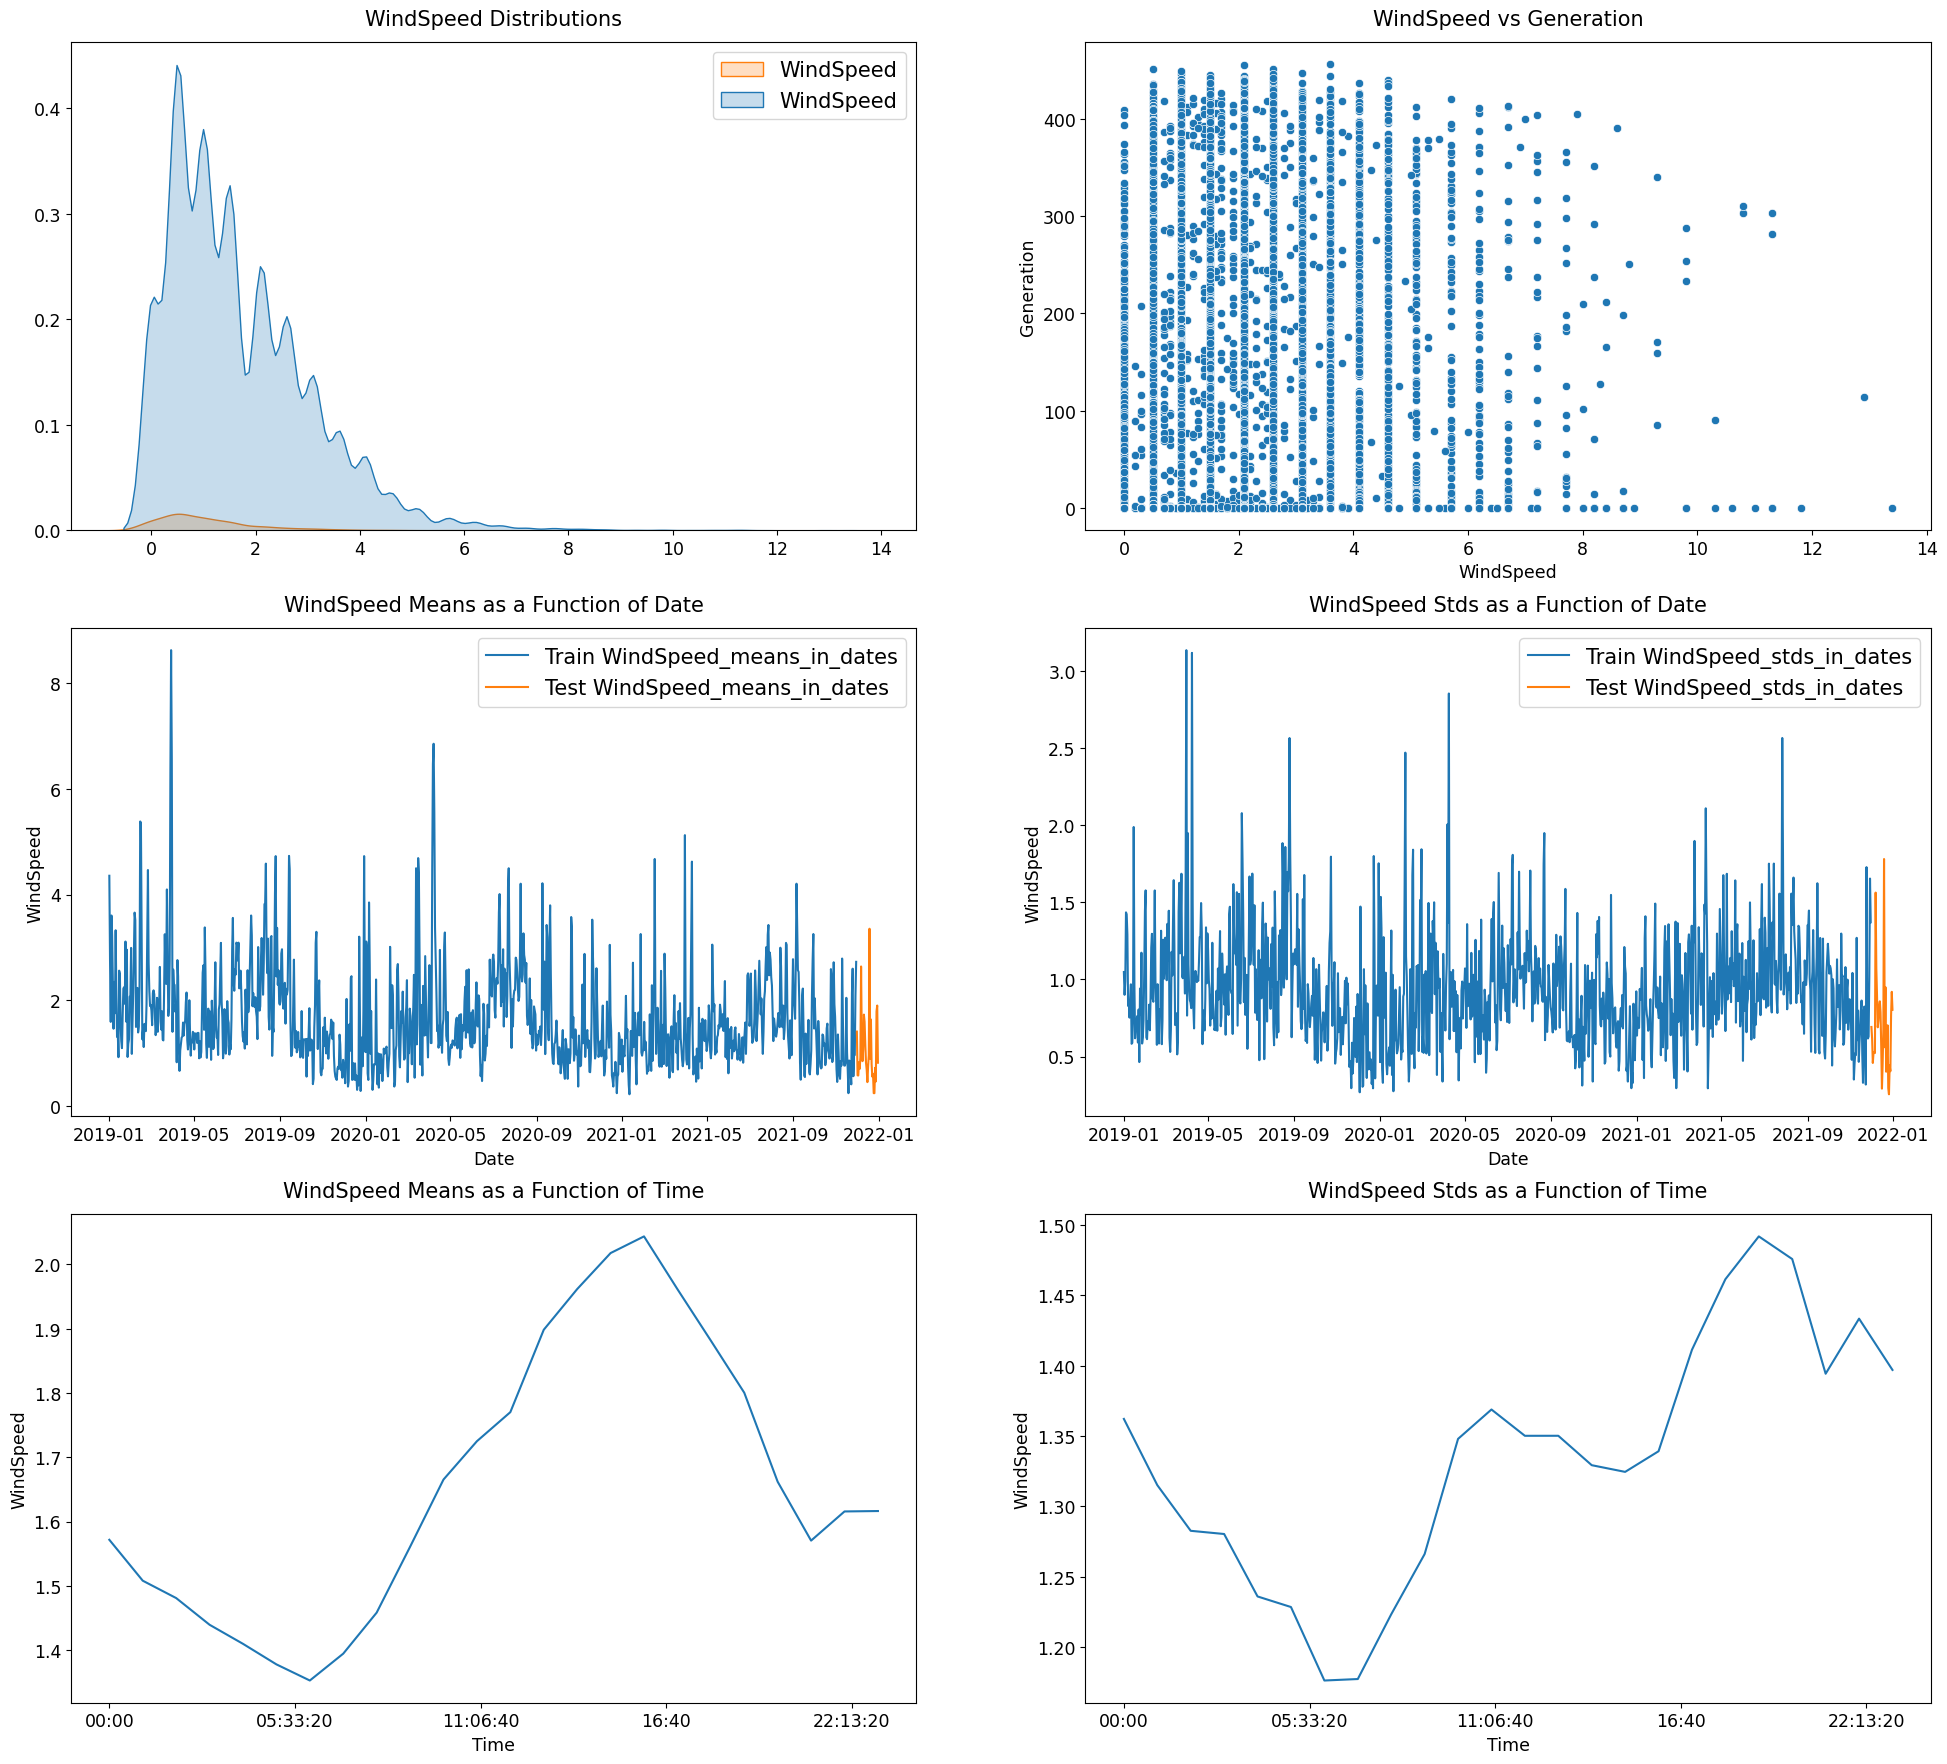

WindDirection
-------------
Mean: 87.4640  -  Median: 30.0000  -  Std: 100.7550
Min: 0.0000  -  25%: 20.0000  -  50%: 30.0000  -  75%: 170.0000  -  Max: 360.0000
Skew: 1.2532  -  Kurtosis: 0.2569
Missing Values: 0/26304 (0.0000%)


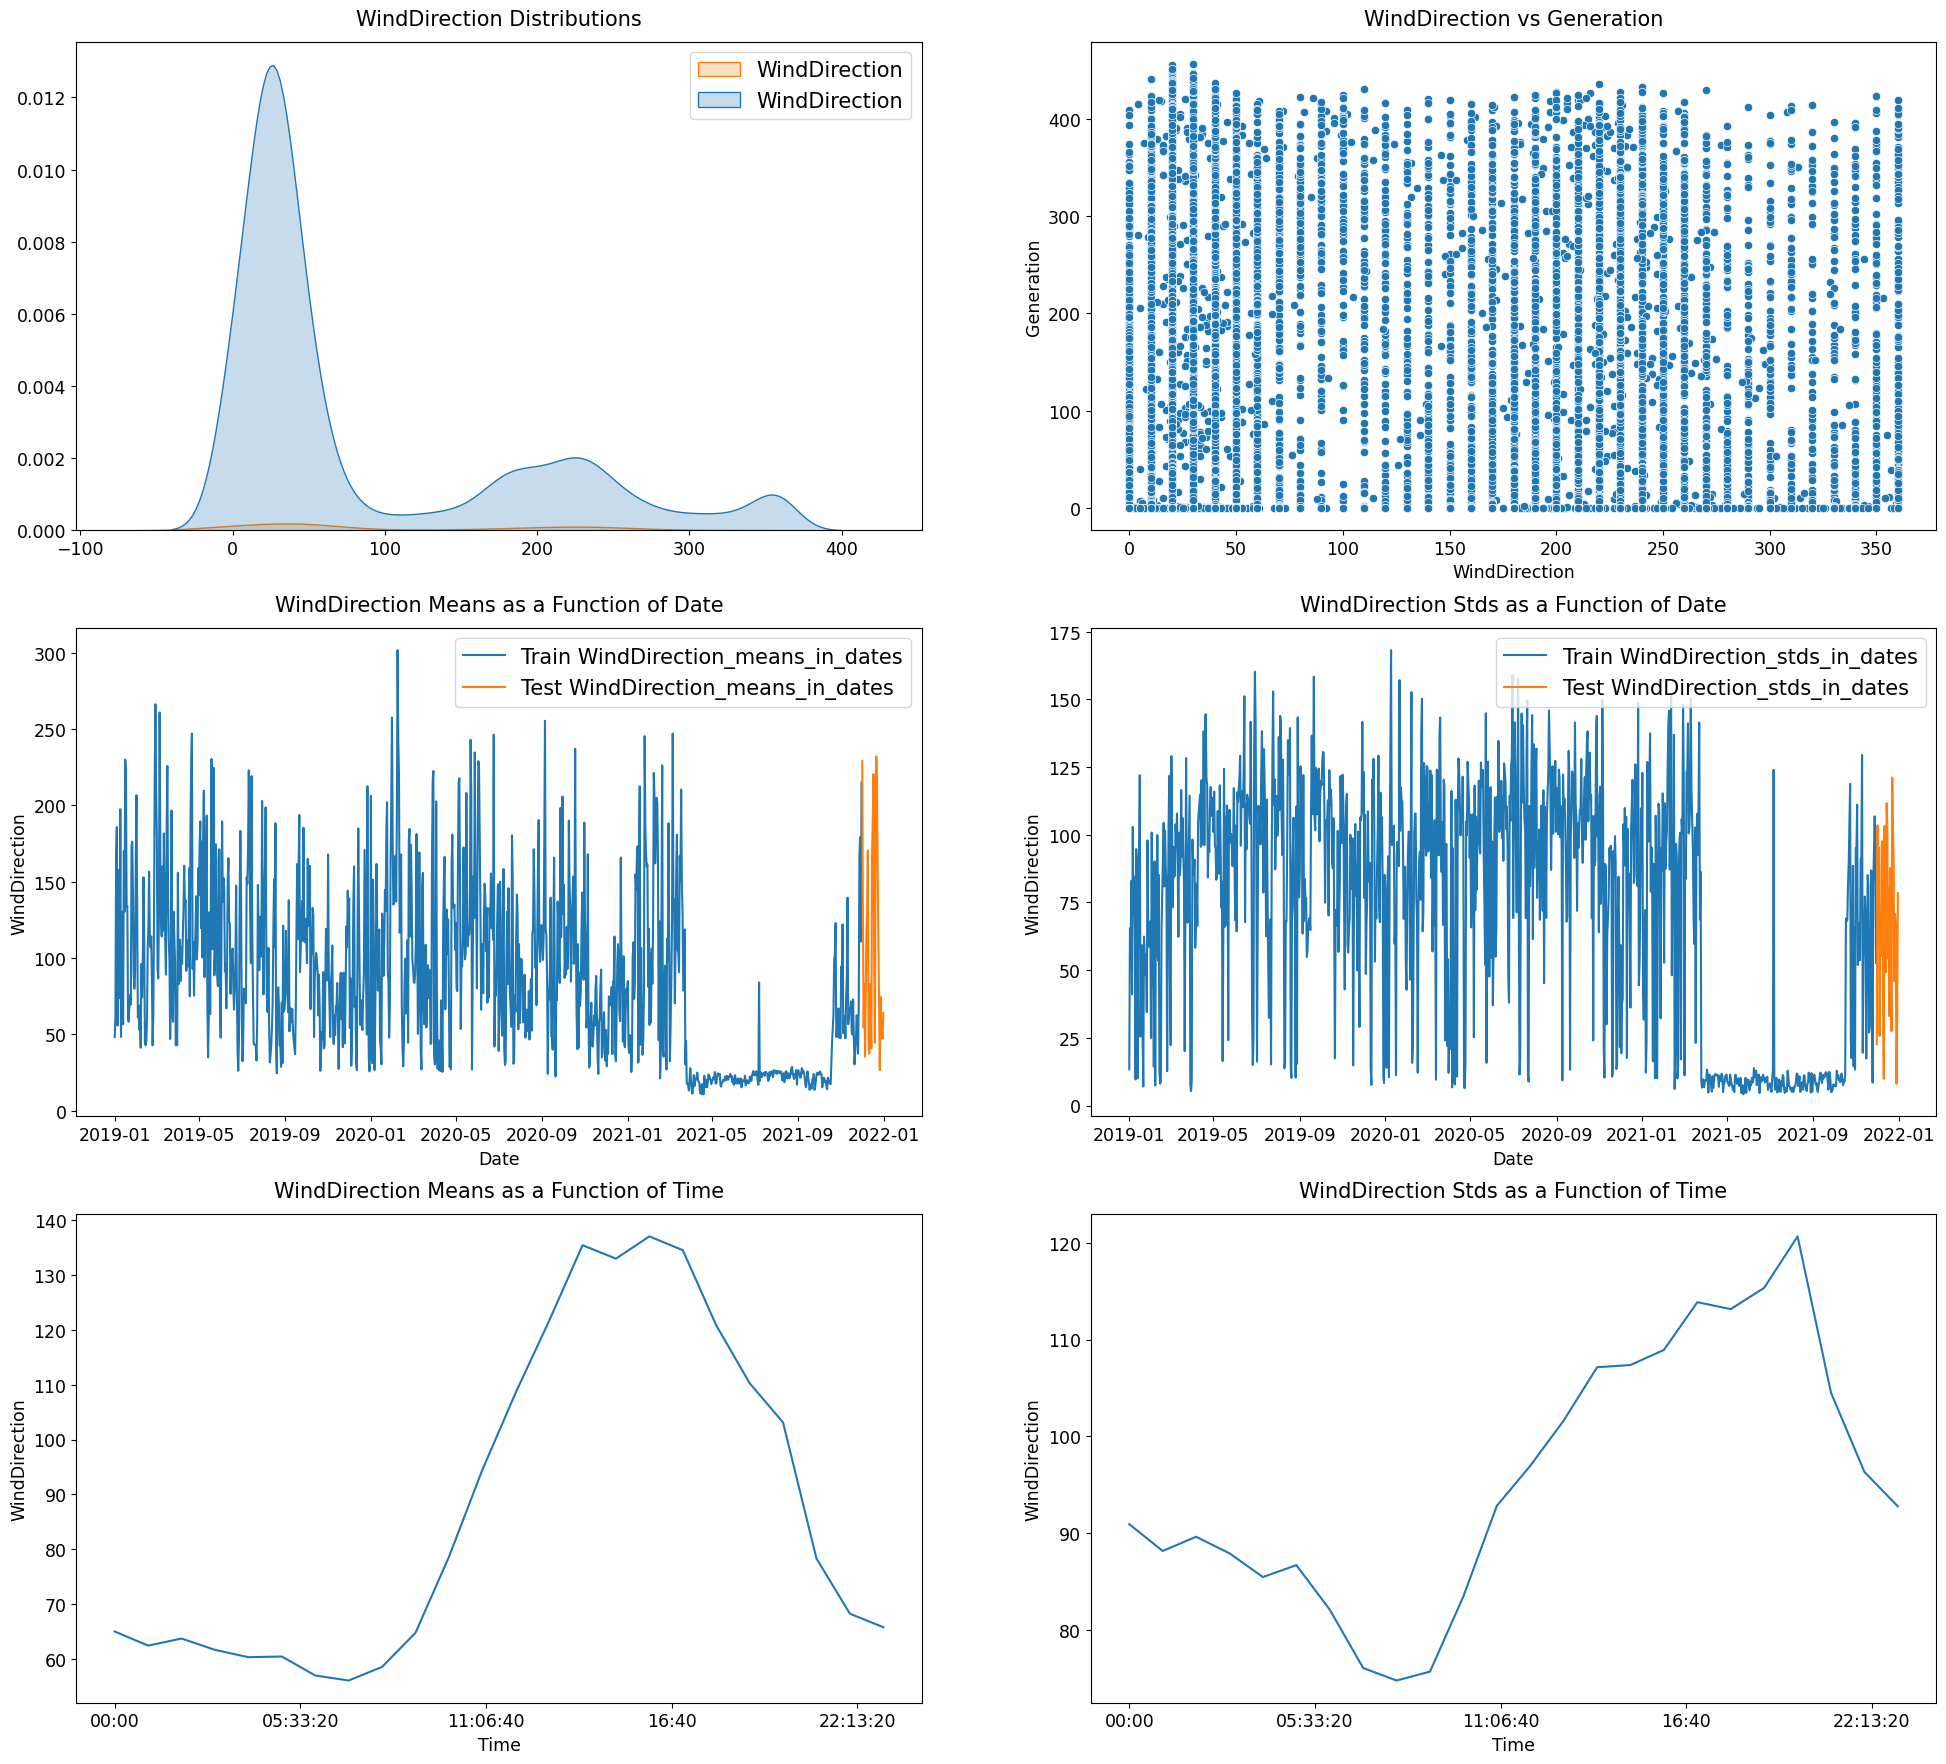

WWCode
------
Mean: 13.0957  -  Median: 3.0000  -  Std: 24.4701
Min: 0.0000  -  25%: 0.0000  -  50%: 3.0000  -  75%: 10.0000  -  Max: 99.0000
Skew: 2.1516  -  Kurtosis: 3.2319
Missing Values: 6254/26304 (23.7759%)


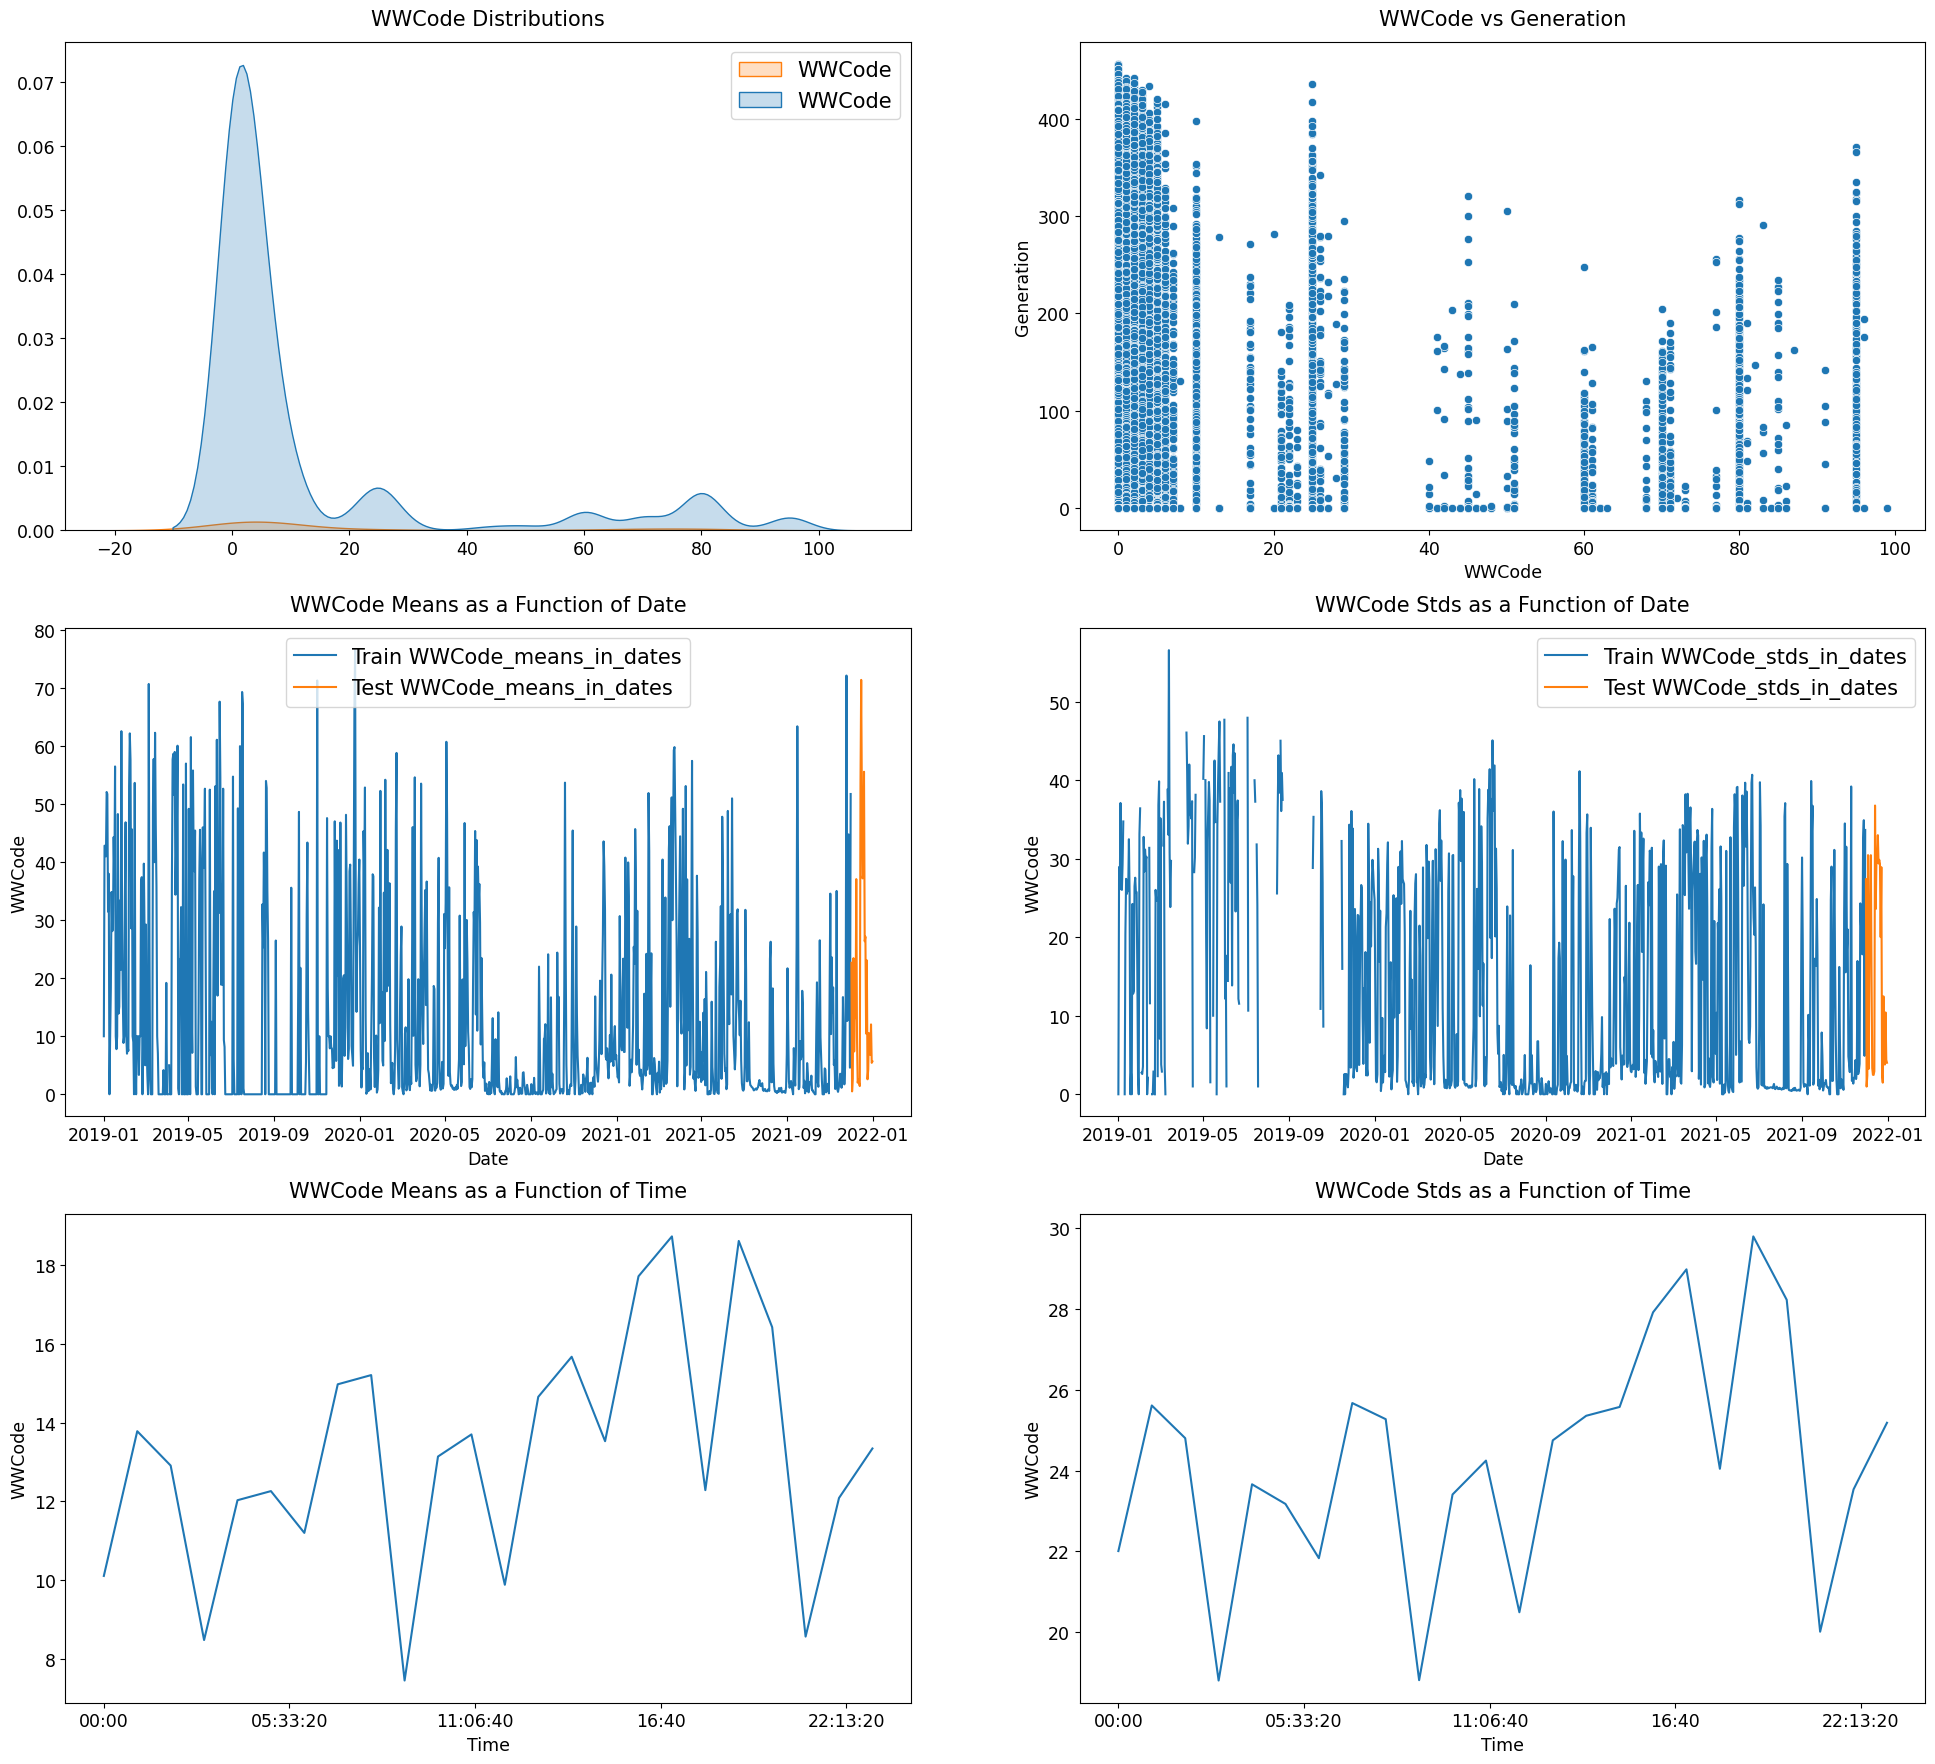

EffectiveCloudCover
-------------------
Mean: 2.6141  -  Median: 2.1000  -  Std: 2.4976
Min: 0.0000  -  25%: 0.0000  -  50%: 2.1000  -  75%: 5.0000  -  Max: 8.0000
Skew: 0.3249  -  Kurtosis: -1.3494
Missing Values: 0/26304 (0.0000%)


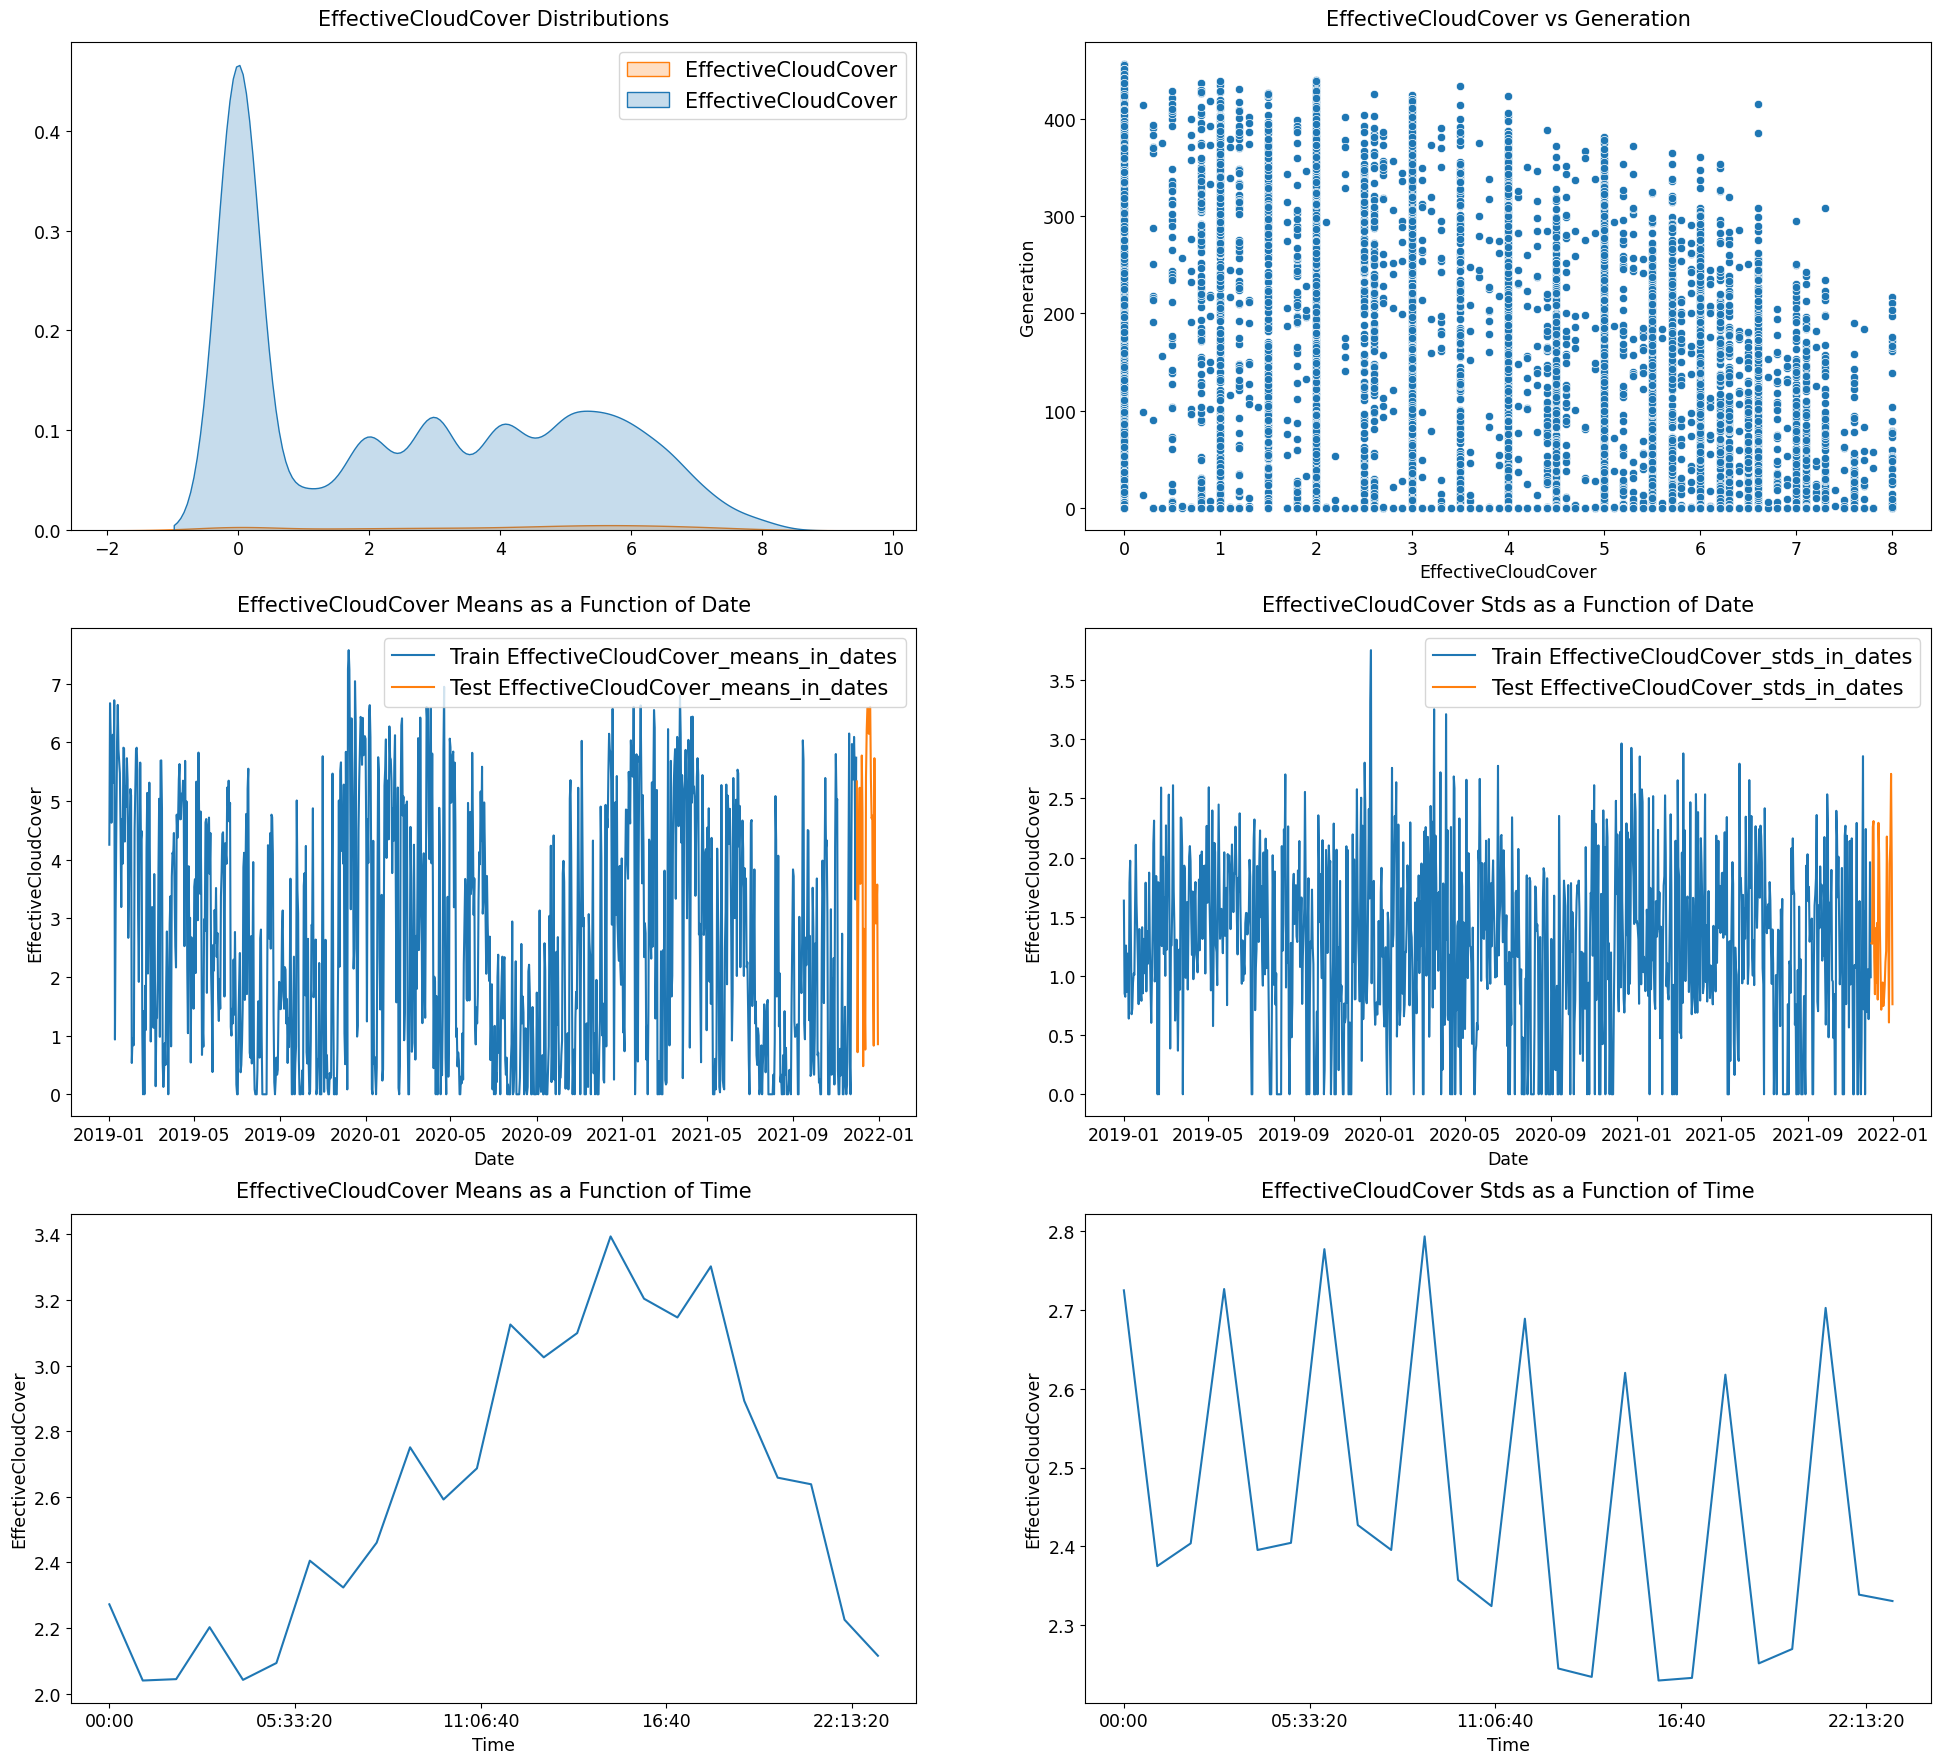

In [13]:
df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)
df_all['Dataset'] = 'train'
df_all.loc[df_all['DateTime'] >= '2021-12-01 00:00:00', 'Dataset'] = 'test'

features = ['AirTemperature', 'ComfortTemperature', 'RelativeHumidity', 'WindSpeed', 'WindDirection', 'WWCode', 'EffectiveCloudCover']
for feature in features:
    visualize_feature(df_all, feature)